# Chap5 係り受け解析

In [9]:
import CaboCha
import re
import pydot_ng as pydot
import graphviz

In [10]:
def parse():
    '''
    neko.txt.cabochaを作る
    '''
    with open("./neko.txt") as f:
        with open("./neko.txt.cabocha","w") as outFile:
            cabocha = CaboCha.Parser()
            for line in f:
                outFile.write(cabocha.parse(line).toString(CaboCha.FORMAT_LATTICE))
            

In [32]:
! head -n 10 ./neko.txt.cabocha

* 0 -1D 0/0 0.000000
一	名詞,数,*,*,*,*,一,イチ,イチ
EOS
EOS
* 0 2D 0/0 -0.764522
　	記号,空白,*,*,*,*,　,　,　
* 1 2D 0/1 -0.764522
吾輩	名詞,代名詞,一般,*,*,*,吾輩,ワガハイ,ワガハイ
は	助詞,係助詞,*,*,*,*,は,ハ,ワ
* 2 -1D 0/2 0.000000


# 40 係り受け解析結果の読み込み

In [12]:
class Morph:
    '''
    形態素を表すクラス
    surface:表層系
    base:基本形
    pos:品詞
    po1:品詞再分類
    '''
    def __init__(self,surface,base,pos,pos1):
        self.surface=surface
        self.base=base
        self.pos=pos
        self.pos1=pos1
    
    def __str__(self):
        '''オブジェクトの文字列表現'''
        return "surface:{},base:{},pos:{},pos1:{}".format(self.surface,self.base,self.pos,self.pos1)
    


表層形 （Tab区切り）
品詞、品詞細分類1,品詞細分類2,品詞細分類3,活用形,活用型,原形,読み,発音

In [35]:
def morph_lines():
    '''
    係り受け解析結果のジェネレータ
    '''
    with open("./neko.txt.cabocha") as file:
        morphs=[]
        for line in file:
            #文の終わりに、一文の形態素解析結果を yield
            if line=="EOS\n":
                if len(morphs)>0:
                    yield morphs
                    morphs=[]
            else:
                if line[0]=='*':
                    #解析結果の数値的な情報か。これは、結果に加えない。
                    continue
                else:
                    cols = line.split('\t')
                    res_cols=cols[1].split(',')
                    new_morph=Morph(cols[0],res_cols[6],res_cols[0],res_cols[1])
                    morphs.append(
                       new_morph
                    )

In [30]:
parse()

In [63]:
for i,morphs in enumerate(morph_lines()):
    if i==3:
        print("{}文め".format(i))
        for morph in morphs:
            print(morph)
        break

3文め
surface:　,base:　,pos:記号,pos1:空白
surface:どこ,base:どこ,pos:名詞,pos1:代名詞
surface:で,base:で,pos:助詞,pos1:格助詞
surface:生れ,base:生れる,pos:動詞,pos1:自立
surface:た,base:た,pos:助動詞,pos1:*
surface:か,base:か,pos:助詞,pos1:副助詞／並立助詞／終助詞
surface:とんと,base:とんと,pos:副詞,pos1:一般
surface:見当,base:見当,pos:名詞,pos1:サ変接続
surface:が,base:が,pos:助詞,pos1:格助詞
surface:つか,base:つく,pos:動詞,pos1:自立
surface:ぬ,base:ぬ,pos:助動詞,pos1:*
surface:。,base:。,pos:記号,pos1:句点


# 41 Chunk　クラスの実装

In [134]:
class Chunk:
    '''
    文節を表す
    morphs:Morphのlist
    dst: かかり先文節のインデックス番号
    srcs:かかり元文節のインデックス番号のlist
    
    functions:
    
    remove_punctuation: 記号を取り除く
    contain_pos_in_morph(pos): posを含むかをみる-> bool
    '''
    def __init__(self):
        self.morphs=[]
        self.srcs=[]
        self.dst=-1
    
    def __str__(self):      
        surface = ''
        for morph in self.morphs:
            surface += morph.surface
        return 'surface:{}\tsrcs:{}\tdst:[{}]'.format(surface, self.srcs, self.dst)
    
    def remove_punctuation(self)->str:
        '''
        記号を取り除く'''
        ret=''
        for morph in self.morphs:
            if morph.pos != '記号':
                ret += morph.surface
        return ret
    
    def contain_pos_in_morphs(self,searchPos)->bool:
        '''
        chunkのなかにseachPos(品詞名)を含むか
        ret:bool
        '''        
        for morph in self.morphs:
            if morph.pos==searchPos:
                return True
        return False
    
    def get_pos_in_morphs(self,pos,pos1="")->list(chunk):
        '''
        morphsにposを含むchunkのlistをreturn'''
        ret=[]
        if len(pos1)>0:
            return [res for res in self.morphs if res.pos==pos and res.pos1==pos1]
        else:
            return [res for res in self.morphs if res.pos==pos]
        
    def get_particle_chunks(self):
        particles = self.get_pos_in_morphs('助詞')
        if len(particles)>0:
            return particles[-1].surface
        else:
            return ''
        
    def get_sahen_wo(self):
        '''
        [さ変接続名詞+を]を含む場合は、surfaceを返す
        '''
        for i,morph in enumerate(self.morphs[0:-1]):
            if morph.pos=="名詞" \
                and morph.pos1=="サ変接続" \
                and self.morphs[i+1].pos =="助詞" \
                and self.morphs[i+1].surface=="を":
                    #複数ある場合はもっとも左の動詞のみでいいから、return してる
                    return morph.surface+self.morphs[i+1].surface
        return ''
                                             
    
    def noun_masked_surface(self,mask,dst=False):
        '''
        名詞を指定文字(mask)でマスクしたsurfaceを返す
        '''
        result =''
        for morph in self.morphs:
            if morph.pos != '記号':
                if morph.pos=="名詞":
                    result+=mask
                    if dst:
                        return result
                masK=''
            else:
                result += morph.surface
        return result
        
        

\*で始まる行  
* \* 文節番号 係り先の文節番号(係り先なし:-1) 主辞の形態素番号/機能語の形態素番号 係り関係のスコア(大きい方が係りやすい)


In [64]:
def chunk_lines():
    '''
    係り受け解析
    '''
    with open("./neko.txt.cabocha") as file:
        chunks=dict() #すでにでてきた、文節番号
        idx=-1 #文節番号
        
        for line in file:
            if line=="EOS\n": #一文づつの解析ー>一文の終わりでreturn
                if len(chunks)>0:
                    #chunksを文節番号順に並べる。
                    sorted_tuple = sorted(chunks.items(),key=lambda x:x[0])
                    ret=[]
                    for chunk in sorted_tuple:
                        ret.append(chunk[1])
                    yield ret
                    chunks.clear()
                
            elif line[0]=="*":#係り受けの情報
                cols=line.split(' ')
                idx=int(cols[1])
                dst_reg = re.search(r'(.*?)D',cols[2])  #(num)Dのnumがかかり先dst
                dst = int(dst_reg.group(1))
                
                if idx not in chunks:
                    chunks[idx]=Chunk()
                chunks[idx].dst=dst
                
                if dst != -1:
                    if dst not in chunks:
                        chunks[dst]=Chunk()
                    chunks[dst].srcs.append(idx)
            else:#morphの情報
                cols = line.split("\t")
                res_cols=cols[1].split(",")
                
                chunks[idx].morphs.append(
                    Morph(
                        cols[0],
                        res_cols[6],
                        res_cols[0],
                        res_cols[1])
                )

In [68]:
for i,chunks in enumerate(chunk_lines()):
    if i==8:
        for j,chunk in enumerate(chunks):
            print("chunk {}".format(j))
            print(chunk)
        break

chunk 0
surface:しかし	srcs:[]	dst:[9]
chunk 1
surface:その	srcs:[]	dst:[2]
chunk 2
surface:当時は	srcs:[1]	dst:[5]
chunk 3
surface:何という	srcs:[]	dst:[4]
chunk 4
surface:考も	srcs:[3]	dst:[5]
chunk 5
surface:なかったから	srcs:[2, 4]	dst:[9]
chunk 6
surface:別段	srcs:[]	dst:[7]
chunk 7
surface:恐し	srcs:[6]	dst:[9]
chunk 8
surface:いとも	srcs:[]	dst:[9]
chunk 9
surface:思わなかった。	srcs:[0, 5, 7, 8]	dst:[-1]


# 42 かかり元とかかり先の文節の表示

In [75]:
for chunks in chunk_lines():
    for chunk in chunks:
        if chunk.dst != -1:#chunkのかかり先がある場合
            src_str = chunk.remove_punctuation()
            dst_str = chunks[chunk.dst].remove_punctuation()
            if src_str != '' and dst_str != '':
                print("{}\t{}".format(src_str,dst_str))

吾輩は	猫である
名前は	無い
まだ	無い
どこで	生れたか
生れたか	つかぬ
とんと	つかぬ
見当が	つかぬ
何でも	薄暗い
薄暗い	所で
じめじめした	所で
所で	泣いて
ニャーニャー	泣いて
泣いて	記憶している
いた事だけは	記憶している
吾輩は	見た
ここで	始めて
始めて	人間という
人間という	ものを
ものを	見た
しかも	種族であったそうだ
あとで	聞くと
聞くと	種族であったそうだ
それは	種族であったそうだ
書生という	人間中で
人間中で	種族であったそうだ
一番	獰悪な
獰悪な	種族であったそうだ
この	書生というのは
書生というのは	話である
時々	捕えて
我々を	捕えて
捕えて	煮て
煮て	食うという
食うという	話である
しかし	思わなかった
その	当時は
当時は	なかったから
何という	考も
考も	なかったから
なかったから	思わなかった
別段	恐し
恐し	思わなかった
いとも	思わなかった
ただ	載せられて
彼の	掌に
掌に	載せられて
載せられて	持ち上げられた
スーと	持ち上げられた
持ち上げられた	時
時	フワフワした
何だか	フワフワした
フワフワした	感じが
感じが	あったばかりである
掌の	上で
上で	落ちついて
少し	落ちついて
落ちついて	見たのが
書生の	顔を
顔を	見たのが
見たのが	人間という
いわゆる	人間という
人間という	ものの
ものの	見始であろう
この	時
時	ものだと
妙な	ものだと
ものだと	思った
思った	感じが
感じが	残っている
今でも	残っている
第一毛をもって	装飾されべきはずの
装飾されべきはずの	顔が
顔が	つるつるして
つるつるして	薬缶だ
まるで	薬缶だ
その後	逢ったが
猫にも	逢ったが
だいぶ	逢ったが
逢ったが	ない
こんな	片輪には
片輪には	ない
一度も	出会わした
出会わした	事が
事が	ない
のみならず	突起している
顔の	真中が
真中が	突起している
あまりに	突起している
そうして	吹く
その穴の	中から
中から	吹く
時々	吹く
ぷうぷうと煙を	吹く
どうも	咽せぽくて
咽せぽくて	弱った
実に	弱った
これが	ものである
人間の	飲む
飲む	煙草という
煙草という	ものである
ものである	事は
事は	知った
ようやく	知った
この	頃
頃	知った
この	書生の

ものが	睡られる
かくまで	睡られる
平気に	睡られる
睡られる	ものかと
ものかと	驚かざるを得なかった
吾輩は	驚かざるを得なかった
窃かに	驚かざるを得なかった
その	度胸に
大胆なる	度胸に
度胸に	驚かざるを得なかった
彼は	黒猫である
純粋の	黒猫である
わずかに	過ぎたる
午を	過ぎたる
過ぎたる	太陽は
太陽は	思われた
透明なる	光線を
光線を	かけて
彼の	皮膚の
皮膚の	上に
上に	かけて
抛げ	かけて
かけて	する
きらきら	する
する	柔毛の
柔毛の	間より
間より	見えぬ
眼に	見えぬ
見えぬ	炎でも
炎でも	思われた
燃え出ずるように	思われた
彼は	有している
猫中の	大王とも
大王とも	云うべき
云うべき	ほどの
ほどの	体格を
偉大なる	体格を
体格を	有している
吾輩の	倍は
倍は	ある
たしかに	ある
吾輩は	落ちた
嘆賞の	念と
念と	佇立して
好奇の	心に
心に	忘れて
前後を	忘れて
忘れて	佇立して
彼の	前に
前に	佇立して
佇立して	眺めていると
余念も	なく
なく	眺めていると
眺めていると	落ちた
静かなる	小春の
小春の	風が
風が	落ちた
杉垣の	上から
上から	出たる
出たる	梧桐の
梧桐の	枝を
枝を	誘って
軽く	誘って
誘って	落ちた
ばらばらと	二三枚の
二三枚の	葉が
葉が	落ちた
枯菊の	茂みに
茂みに	落ちた
大王は	開いた
かっと	開いた
その	真丸の
真丸の	眼を
眼を	開いた
今でも	記憶している
その	眼は
眼は	輝いていた
人間の	珍重する
珍重する	琥珀という
琥珀という	ものよりも
ものよりも	輝いていた
遥かに	美しく
美しく	輝いていた
彼は	しない
身動きも	しない
双眸の	奥から
奥から	射るごとき
射るごとき	光を
光を	あつめて
吾輩の	額の
矮小なる	額の
額の	上に
上に	あつめて
あつめて	云った
御めえは	云った
一体	云った
何だと	云った
大王に	しては
しては	卑しいと
少々	卑しいと
言葉が	卑しいと
卑しいと	思ったが
思ったが	抱いた
何しろ	挫し
その	声の
声の	底に
底に	挫し
犬をも	挫し
挫し	籠っているので
ぐべき力が	籠っているので
籠っているので	抱いた
吾輩は	抱いた
少なからず	抱いた
恐れを	抱いた
しかし	猫である
挨拶を

少し	ある
眼識の	ある
ある	ものなら
ものなら	描いてある
猫の	中でも
中でも	猫じゃない
他の	猫じゃない
猫じゃない	吾輩である
吾輩である	事が
事が	わかるように
判然と	わかるように
わかるように	描いてある
立派に	描いてある
この	くらい
くらい	苦心するかと
明瞭な	事を
事を	分らずに
分らずに	苦心するかと
かくまで	苦心するかと
苦心するかと	思うと
思うと	気の毒になる
少し	気の毒になる
人間が	気の毒になる
出来る事なら	知らしてやりたい
その	絵が
絵が	云う
吾輩であると	云う
云う	事を
事を	知らしてやりたい
吾輩であると	云う
云う	事は
事は	分らないにしても
よし	分らないにしても
分らないにしても	分らしてやりたい
せめて	分らしてやりたい
猫であるという	事だけは
事だけは	分らしてやりたい
しかし	しておいた
人間という	ものは
ものは	おらん動物であるから
到底	解し得る
吾輩	猫属の
猫属の	言語を
言語を	解し得る
解し得る	くらいに
くらいに	浴して
天の	恵に
恵に	浴して
浴して	おらん動物であるから
おらん動物であるから	しておいた
残念ながら	しておいた
そのままに	しておいた
ちょっと	断っておきたいが
読者に	断っておきたいが
断っておきたいが	よくない
元来	何ぞと
人間が	何ぞと
何ぞと	いうと
いうと	よくない
猫と	評価する
事もなげに	もって
軽侮の	口調を
口調を	もって
もって	評価する
吾輩を	評価する
評価する	癖が
癖が	あるは
あるは	よくない
はなはだ	よくない
人間の	糟から
糟から	出来て
牛と	馬が
馬が	出来て
出来て	考えるのは
牛と	馬の
馬の	糞から
糞から	製造されたごとく
猫が	製造されたごとく
製造されたごとく	考えるのは
考えるのは	事でもあろうが
自分の	無智に
無智に	心付かんで
心付かんで	する
高慢な	顔を
顔を	する
する	教師などには
教師などには	事でもあろうが
ありがちの	事でもあろうが
事でもあろうが	者じゃない
はたから	見て
見て	見っとも
あまり	見っとも
見っとも	者じゃない
いい	者じゃない
いくら	出来ぬ
猫だって	出来ぬ
そう	出来ぬ
粗末簡便には	出来ぬ
よそ目には	特色などはないようであるが
一列一体	平等無差別

男じゃあるまいし	止すがいいと
止すがいいと	冷かしたから
冷かしたから	廃してしまった
この	頃は
頃は	廃してしまった
先生は	云うから
蕎麦を	食ったら
食ったら	よかろうと
よかろうと	云うから
云うから	食ったが
早速	食ったが
かけともりを	食ったが
かわるがわる	食ったが
食ったが	なかった
これは	なかった
腹が	下るばかりで
下るばかりで	なかった
何等の	功能も
功能も	なかった
余は	駄目である
年来の	胃弱を
胃弱を	直す
直す	ために
ために	出来得る
出来得る	限りの
限りの	方法を
方法を	講じて
講じて	見たが
見たが	駄目である
すべて	駄目である
ただ	ある
昨夜	傾けた
寒月と	傾けた
傾けた	正宗は
三杯の	正宗は
正宗は	ある
たしかに	ある
利目が	ある
これからは	しよう
毎晩	二三杯ずつ
二三杯ずつ	飲む
飲む	事に
事に	しよう
これも	続く
決して	続く
長く	続く
続く	事は
事は	あるまい
主人の	心は
心は	変化している
吾輩の	眼球のように
眼球のように	なく
間断	なく
なく	変化している
何を	やっても
やっても	しない
永持の	しない
しない	男である
その上	おかしい
日記の	上で
上で	心配している
胃病を	心配している
こんなに	心配している
心配している	癖に
癖に	おかしい
表向は	おかしい
大に	するから
痩我慢を	するから
するから	おかしい
せんだって	尋ねて来て
その	友人で
友人で	尋ねて来て
某という	学者が
学者が	尋ねて来て
尋ねて来て	ほかならないと
一種の	見地から
見地から	ほかならないと
すべての	病気は
病気は	ほかならないと
父祖の	罪悪と
罪悪と	罪悪の
自己の	罪悪の
罪悪の	結果に
結果に	ほかならないと
ほかならないと	云う
云う	議論を
議論を	した
大分研究した	ものと
ものと	見えて
見えて	説であった
条理が	明晰で
明晰で	説であった
秩序が	説であった
整然として	説であった
立派な	説であった
気の毒ながら	ないのである
うちの	主人などは
主人などは	ないのである
到底	反駁する
これを	反駁する
反駁する	ほどの
ほどの	頭脳も
頭脳も	学問も
学問も	ないのである
しかし	した
自分が	苦しんでいる
胃病で	苦しんでいる
苦しんでいる	

さあ	趣向というのが
その	趣向というのが
趣向というのが	分らなかったんですが
その	時は
時は	分らなかったんですが
私にも	分らなかったんですが
分らなかったんですが	あるのだろうと
いずれ	事ですから
あの	方の
方の	事ですから
事ですから	あるのだろうと
何か	あるのだろうと
面白い	種が
種が	あるのだろうと
あるのだろうと	思いまして
思いまして	驚いたのです
いっしょに	行きましたか
行きましたか	なるほど
なるほど	驚いたのです
ところが	驚いたのです
驚いたのです	主人は
主人は	云わぬばかりに
それ	見たかと
見たかと	云わぬばかりに
云わぬばかりに	叩く
膝の	上に
上に	乗った
乗った	吾輩の
吾輩の	頭を
頭を	叩く
ぽかと	叩く
少し	痛い
また	事なんでしょう
馬鹿な	茶番
茶番	見たような
見たような	事なんでしょう
あの	男は
男は	癖でねと
あれが	癖でねと
癖でねと	思い出す
急に	思い出す
アンドレア・デル・サルト事件を	思い出す
君	変った
何か	変った
変った	ものを
ものを	食おうじゃないかと
食おうじゃないかと	おっしゃるので
おっしゃるので	食いました
何を	食いました
食いました	ありました
まず	見ながら
献立を	見ながら
見ながら	ありました
いろいろ	ありました
料理についての	御話しが
御話しが	ありました
ありました	前にですか
誂らえ	ない
ない	前にですか
前にですか	ええ
ええ	それから
それから	黙っていましたよ
それから	捻って
首を	捻って
捻って	なって
ボイの	方を
方を	なって
御覧に	なって
なって	変った
どうも	変った
変った	ものも
ものも	ないようだなと
ないようだなと	おっしゃると
おっしゃると	黙っていましたよ
ボイは	黙っていましたよ
負けぬ	気で
気で	云うと
鴨の	ロースか
ロースか	チャップなどは
小牛の	チャップなどは
チャップなどは	云うと
如何ですと	云うと
云うと	黙っていましたよ
先生は	おっしゃるんで
そんな	月並を
月並を	食いに
食いに	来やしないと
わざわざ	来やしないと
ここまで	来やしないと
来やしないと	おっしゃるんで
おっしゃるんで	黙っていましたよ
ボイは	月並という
月並という	意味が
意味が	分らん
分らん	ものですから
ものです

私しが	使って
船頭の	仮色を
仮色を	使って
使って	やっていると
ようやく	調子づいて
調子づいて	大丈夫と
これなら	大丈夫と
大丈夫と	思って
思って	やっていると
得意に	やっていると
やっていると	ものですから
つまり	あまり過ぎたのでしょう
身振りが	あまり過ぎたのでしょう
あまり過ぎたのでしょう	ものですから
今まで	えていた
耐ら	えていた
えていた	女学生が
女学生が	笑いだした
一度に	笑いだした
わっと	笑いだした
笑いだした	ものですから
ものですから	驚ろいたし
驚ろいた事も	驚ろいたし
驚ろいたし	悪るいし
極りが	悪るいし
悪るい事も	悪るいし
悪るいし	折られてから
それで	折られてから
腰を	折られてから
折られてから	つづけられないので
どうしても	つづけられないので
後が	つづけられないので
つづけられないので	散会しました
とうとう	散会しました
それ限りで	散会しました
散会しました	第一回としては
第一回としては	ものだろうと
成功だと	称する
称する	朗読会が
朗読会が	ものだろうと
これでは	ものだろうと
失敗は	ものだろうと
どんな	ものだろうと
ものだろうと	想像すると
想像すると	笑わずにはいられない
覚えず	鳴る
咽喉仏が	鳴る
ごろごろ	鳴る
主人は	撫でてくれる
いよいよ	撫でてくれる
柔かに	撫でてくれる
頭を	撫でてくれる
人を	笑って
笑って	可愛がられるのは
可愛がられるのは	ありがたいが
ありがたいが	ある
いささか	無気味な
無気味な	ところも
ところも	ある
それは	事でと
飛んだ	事でと
事でと	述べている
主人は	述べている
正月	述べている
早々	述べている
弔詞を	述べている
第二回からは	やるつもりなので
もっと	奮発して
奮発して	やるつもりなので
盛大に	やるつもりなので
やるつもりなので	仰ぎたいので
今日	出ましたのも
出ましたのも	ためで
全く	ためで
その	ためで
ためで	仰ぎたいので
実は	仰ぎたいので
先生にも	仰ぎたいので
一つ御入会の	上
上	仰ぎたいので
御尽力を	仰ぎたいので
仰ぎたいので	断わりかける
僕には	起せませんよと
とても	起せませんよと
癪なんか	起せませんよと
起せませんよと	断わりかける
消極的の	主人は
主人は	断わりかける
すぐに	断わ

一度に	とる
迷亭君は	笑う
気にも	留めない
留めない	様子で
様子で	笑う
どうせ	格だからなあと
僕などは	格だからなあと
行徳の	俎と
俎と	云う
云う	格だからなあと
格だからなあと	笑う
まず	ところだろうと
そんな	ところだろうと
ところだろうと	云う
主人が	云う
実は	解さないのであるが
行徳の	俎と
俎と	云う
云う	語を
語を	解さないのであるが
主人は	解さないのであるが
解さないのであるが	応用するのである
さすが	して
永年教師を	して
して	胡魔化しつけている
胡魔化しつけている	ものだから
ものだから	応用するのである
こんな	時には
時には	応用するのである
教場の	経験を
経験を	応用するのである
社交上にも	応用するのである
行徳の	俎というのは
俎というのは	事ですかと
何の	事ですかと
事ですかと	聞く
寒月が	聞く
真率に	聞く
主人は	ねじ伏せる
床の	方を
方を	見て
見て	ねじ伏せる
あの	水仙は
水仙は	挿したのだが
暮に	買って来て
僕が	買って来て
風呂の	帰りがけに
帰りがけに	買って来て
買って来て	挿したのだが
挿したのだが	持つじゃないかと
よく	持つじゃないかと
持つじゃないかと	ねじ伏せる
行徳の	俎を
俎を	ねじ伏せる
無理に	ねじ伏せる
暮と	いえば
いえば	したよと
去年の	暮に
暮に	したよと
僕は	したよと
実に	不思議な
不思議な	経験を
経験を	したよと
したよと	廻わす
迷亭が	廻わす
煙管を	廻わす
大神楽のごとく	廻わす
指の	廻わす
尖で	廻わす
どんな	経験か
経験か	聞かし玉えと
聞かし玉えと	つく
主人は	つく
行徳の	俎を
俎を	見捨てた
遠く	後に
後に	見捨てた
見捨てた	気で
気で	つく
ほっと	つく
息を	つく
迷亭先生の	経験というのを
不思議な	経験というのを
経験というのを	聞くと
聞くと	左のごとくである
たしか	記憶しているがね
暮の	二十七日と
二十七日と	記憶しているがね
例の	東風から
東風から	伺いたいから
参堂の	上
上	伺いたいから
是非文芸上の	御高話を
御高話を	伺いたいから
伺いたいから	願うと
御在宿を	願うと
願うと	云う
云う	先き
先き	触れが
触れが	あったので
あったので	来ないやね
朝から	待っていると
心待ちに	待って

四時までに	全快して
全快して	履行する
約束を	履行する
履行する	事が
事が	出来なかったら
出来なかったら	するかも知れない
気の	狭い
狭い	女の
女の	事だから
事だから	するかも知れない
何を	するかも知れない
情けない	仕儀に
仕儀に	なって来た
どう	したら
したら	善かろう
万一の	事を
事を	考えると
考えると	させるのも
今の	内に
内に	説き聞かして
有為転変の	理
理	道を
生者必滅の	道を
道を	説き聞かして
説き聞かして	起った
もしもの	変が
変が	起った
起った	時
時	取り乱さない
取り乱さない	くらいの
くらいの	覚悟を
覚悟を	させるのも
させるのも	義務ではあるまいかと
夫の	妻に対する
妻に対する	義務ではあるまいかと
義務ではあるまいかと	考え出した
僕は	呼んだよ
速かに	呼んだよ
細君を	呼んだよ
書斎へ	呼んだよ
呼んで	女だけれども
御前は	女だけれども
女だけれども	manyaslip'twixtthecupandthelipと
manyaslip'twixtthecupandthelipと	云う
云う	西洋の
西洋の	諺くらいは
諺くらいは	心得ているだろうと
心得ているだろうと	聞くと
聞くと	なさらなかったんです
そんな	横文字なんか
横文字なんか	知るもんですか
誰が	知るもんですか
知るもんですか	からかうのだから
あなたは	からかうのだから
人が	知らないのを
英語を	知らないのを
知らないのを	からかうのだから
御存じの	癖に
癖に	使って
わざと	使って
英語を	使って
使って	からかうのだから
人に	からかうのだから
からかうのだから	なさらなかったんです
宜しゅうございます	出来ないんですから
どうせ	出来ないんですから
英語なんかは	出来ないんですから
出来ないんですから	なさらなかったんです
そんなに	御好きなら
英語が	御好きなら
御好きなら	なさらなかったんです
なぜ	なさらなかったんです
耶蘇学校の	卒業生かなんかを
卒業生かなんかを	なさらなかったんです
お貰い	なさらなかったんです
あなたくらい	ありはしないと
冷酷な	人は
人は	ありはしないと
ありはしないと	権幕なんで
非常な	権幕なんで
権幕なんで	折られてしまった
僕も	折られてしまった
せっかくの	計画の
計画の	腰

無理は	あるまい
ただ	思って
その	見識を
くらいな	見識を
見識を	有している
有している	吾輩を
吾輩を	思って
やはり	生えた
一般猫児の	毛の
毛の	生えた
生えた	ものくらいに
ものくらいに	思って
思って	喰い尽したのは
主人が	なく
吾輩に	なく
一言の	挨拶も
挨拶も	なく
なく	喰い尽したのは
吉備団子を	喰い尽したのは
わが物顔に	喰い尽したのは
喰い尽したのは	次第である
残念の	次第である
写真も	送らぬ
まだ	撮って
撮って	送らぬ
送らぬ	容子だ
これも	不平だが
不平と	云えば
云えば	不平だが
不平だが	あるまい
主人は	主人
主人	吾輩で
吾輩は	吾輩で
吾輩で	あるまい
相互の	見解が
見解が	自然異なるのは
自然異なるのは	あるまい
致し方も	あるまい
吾輩は	なりすましているのだから
どこまでも	なりすましているのだから
人間に	なりすましているのだから
なりすましているのだから	上りにくい
交際を	せぬ
せぬ	猫の
猫の	動作は
動作は	上りにくい
どうしても	上りにくい
ちょいと	上りにくい
筆に	上りにくい
迷亭	寒月諸先生の
寒月諸先生の	評判だけで
評判だけで	御免蒙る
御免蒙る	事に
事に	致そう
今日は	日曜なので
上天気の	日曜なので
日曜なので	唸っている
主人は	出て来て
のそのそ	出て来て
書斎から	出て来て
出て来て	なって
吾輩の	傍へ
傍へ	並べて
筆硯と	原稿用紙を
原稿用紙を	並べて
並べて	なって
腹這に	なって
なって	唸っている
しきりに	唸っている
何か	唸っている
大方	書き
草稿を	書き
書き	卸す
卸す	序開きとして
序開きとして	発するのだろうと
妙な	声を
声を	発するのだろうと
発するのだろうと	注目していると
注目していると	いた
やや	しばらくして
しばらくして	いた
筆太に	いた
香一とか	いた
はてな詩に	なるか
なるか	なるか
俳句に	なるか
なるか	洒落過ぎているがと
香一とは	洒落過ぎているがと
主人に	しては
しては	洒落過ぎているがと
少し	洒落過ぎているがと
洒落過ぎているがと	思う
思う	間もなく
間もなく	走らせた
彼は	走らせた
香一を	書き放しにして
書き放しにして	走らせた
新たに	走らせた
行を	走らせた
改めて	走らせた
さっきから	かこう

さっきから	待った
二人で	待った
大待ちに	待った
待った	ところなんだ
早速	願おうなあ君と
願おうなあ君と	見る
主人を	見る
主人も	する
やむを得ず	する
うむと	する
生返事を	する
寒月君は	いそがない
コップへ	頂戴しましょうと
水を	頂戴しましょうと
一杯	頂戴しましょうと
頂戴しましょうと	云う
いよー	やるのか
本式に	やるのか
やるのか	なさるだろうと
次には	なさるだろうと
拍手の	請求とおいで
請求とおいで	なさるだろうと
なさるだろうと	騒ぎ立てる
迷亭は	騒ぎ立てる
独りで	騒ぎ立てる
寒月君は	始める
内隠しから	取り出して
草稿を	取り出して
取り出して	して
徐ろに	して
稽古ですから	願いますと
御遠慮なく御批評を	願いますと
願いますと	して
前置を	して
して	始める
いよいよ	始める
演舌の	御浚いを
御浚いを	始める
罪人を	絞
絞	処すると
罪の	刑に
刑に	処すると
処すると	云う
云う	事は
事は	方法でありまして
重に	行われた
アングロサクソン民族間に	行われた
行われた	方法でありまして
方法でありまして	者であります
それより	溯って
古代に	溯って
溯って	考えますと
考えますと	者であります
首縊りは	者であります
重に	行われた
自殺の	方法として
方法として	行われた
行われた	者であります
猶	在っては
太人中に	在っては
在っては	習慣であったそうでございます
罪人を	抛げつけて
石を	抛げつけて
抛げつけて	殺す
殺す	習慣であったそうでございます
旧約全書を	研究して
研究して	見ますと
見ますと	認められます
いわゆる	ハンギングなる
ハンギングなる	語は
語は	認められます
罪人の	死体を
死体を	釣るして
釣るして	する
野獣または	肉食鳥の
肉食鳥の	餌食と
餌食と	する
する	意義と
意義と	認められます
ヘロドタスの	説に従って
説に従って	見ますと
見ますと	思われます
猶	思われます
太人は	思われます
エジプトを	去る
去る	以前から
以前から	曝される
夜中死骸を	曝される
曝される	ことを
ことを	忌み嫌ったように
痛く	忌み嫌ったように
忌み嫌ったように	思われます
エジプト人は	したそうで御座います
罪人の	首を
首を	斬って
斬って	して
胴だけを	して
十字架

寒月さんの	事だけですよ
事だけですよ	奴だと
寒月の	事だって
事だって	奴だと
誰の	事だって——全体あの
事だって——全体あの	神さんは
車屋の	神さんは
神さんは	奴だと
気に	食わん
食わん	奴だと
奴だと	怒り出す
主人は	怒り出す
一人	怒り出す
しかし	立っているのは
あなたの	垣根の
垣根の	そとへ
そとへ	来て
来て	立っているのは
立っているのは	いいでしょうと
向うの	勝手じゃありませんか
勝手じゃありませんか	なさるか
話しが	聞えて
聞えて	なさるか
わるけりゃ	小さい
もっと	小さい
小さい	声で
声で	なさるか
なさるか	御這入んなさるが
もっと	大きな
大きな	うちへ
うちへ	御這入んなさるが
御這入んなさるが	いいでしょうと
いいでしょうと	ない
鼻子は	ない
少しも	赤面した
赤面した	様子が
様子が	ない
新道の	二絃琴の
二絃琴の	師匠からも
師匠からも	聞いています
大分いろいろな	事を
事を	聞いています
聞いています	事をですか
寒月の	事をですか
事をですか	事じゃありませんと
寒月さんばかりの	事じゃありませんと
事じゃありませんと	事を
少し	凄い
凄い	事を
事を	云う
主人は	恐れ入るかと
恐れ入るかと	思うと
思うと	女ですよ
あの	師匠は
師匠は	馬鹿野郎です
いやに	ぶって
上品	ぶって
ぶって	している
自分だけ	人間らしい
人間らしい	顔を
顔を	している
している	馬鹿野郎です
馬鹿野郎です	女ですよ
憚り様	女ですよ
野郎は	御門違いですと
御門違いですと	あらわして来る
鼻子の	言葉使いは
言葉使いは	あらわして来る
ますます	あらわして来る
御里を	あらわして来る
これでは	ものであるが
まるで	来たような
喧嘩を	しに
しに	来たような
来たような	ものであるが
ものであるが	聞いている
そこへ	行くと
行くと	聞いている
迷亭は	聞いている
やはり	聞いている
迷亭で	聞いている
この	談判を
談判を	聞いている
面白そうに	聞いている
鉄枴仙人が	して
軍鶏の	蹴合いを
蹴合いを	見るような
見るような	顔を
顔を	して
して	聞いている
平気で	聞いている
悪口の	交換では
交換では	やむを得ざるに至らしめられていたが
到底	自覚した
鼻子の	敵でないと
敵でないと	自覚した
自覚し

翌日とも	云わず
云わず	出掛けようと
これから	出掛けようと
出掛けようと	起して
勇猛精進の	大決心を
大決心を	起して
起して	出たが
台所まで	飛んで
飛んで	出たが
出たが	考えた
待てよと	考えた
吾輩は	達しているのみならず
猫として	達しているのみならず
進化の	極度に
極度に	達しているのみならず
達しているのみならず	つもりであるが
脳力の	発達においては
発達においては	つもりであるが
あえて	劣らざる
中学の	三年生に
三年生に	劣らざる
劣らざる	つもりであるが
つもりであるが	饒舌れない
悲しいかな	咽喉の
咽喉の	構造だけは
構造だけは	猫なので
どこまでも	猫なので
猫なので	饒舌れない
人間の	言語が
言語が	饒舌れない
よし	忍び込んで
首尾よく	忍び込んで
金田邸へ	忍び込んで
忍び込んで	見届けた
充分	見届けた
敵の	情勢を
情勢を	見届けた
見届けた	ところで
ところで	行かない
肝心の	寒月君に
寒月君に	教えてやる
教えてやる	訳に
訳に	行かない
主人にも	迷亭先生にも
迷亭先生にも	話せない
話せないと	すれば
すれば	光らぬと
土中に	ある
ある	金剛石の
金剛石の	日を
日を	受けて
受けて	光らぬと
光らぬと	同じ
同じ	事で
事で	なる
せっかくの	智識も
智識も	なる
無用の	長物と
長物と	なる
これは	見た
愚だ	見た
やめようかしらんと	上り口で
上り口で	佇んで
佇んで	見た
しかし	残り惜しい
一度	思い立った
思い立った	事を
事を	やめるのは
中途で	やめるのは
やめるのは	残り惜しい
白雨が	来るかと
来るかと	待っている
待っている	時
時	通り過ぎたように
黒雲共隣国へ	通り過ぎたように
通り過ぎたように	残り惜しい
何となく	残り惜しい
それも	格別だが
非が	あれば
こっちに	あれば
あれば	格別だが
格別だが	本懐であろう
いわゆる	正義の
正義の	ため
ため	ためなら
人道の	ためなら
ためなら	本懐であろう
たとい	やるまでも
無駄死を	やるまでも
やるまでも	進むのが
進むのが	本懐であろう
義務を	知る
知る	男児の
男児の	本懐であろう
無駄骨を	折り
折り	汚すくらいは
無駄足を	汚すくらいは
汚すくらいは	ところである
猫として	ところである
適当の	ところである


天下の	珍品として
珍品として	紹介しておきたいと
御両君に	紹介しておきたいと
紹介しておきたいと	思います
思います	云う
寒月君は	云う
思わず	云う
ヒヤヤヤと	云う
しかし	ものであります
物も	達しますと
極度に	達しますと
達しますと	相違ございませんが
偉観には	相違ございませんが
相違ございませんが	ものであります
何となく	怖し
怖し	くて
くて	近づき難い
近づき難い	ものであります
あの	鼻梁などは
鼻梁などは	ございませんが
素晴しいには	ございませんが
違い	ございませんが
ございませんが	峻嶮過ぎるかと
少々	峻嶮過ぎるかと
峻嶮過ぎるかと	思われます
古人の	うちにても
うちにても	ございましょうが
ソクラチス	ゴールドスミスもしくは
ゴールドスミスもしくは	サッカレーの
サッカレーの	鼻などは
鼻などは	ございましょうが
構造の	上から
上から	云うと
云うと	ございましょうが
随分	ございましょうが
申し分は	ございましょうが
ございましょうが	ございます
その	申し分の
申し分の	ある
ある	ところに
ところに	ございます
愛嬌が	ございます
鼻高きが	故に
故に	貴からず
貴からず	奇なるが
奇なるが	貴しとは
ために	貴しとは
貴しとは	故でもございましょうか
この	故でもございましょうか
下世話にも	申しますれば
鼻より	団子と
団子と	申しますれば
申しますれば	申しますと
美的価値から	申しますと
申しますと	適当かと
まず	適当かと
迷亭くらいの	ところが
ところが	適当かと
適当かと	存じます
存じます	主人は
寒月と	主人は
主人は	笑い出す
フフフフと	笑い出す
迷亭自身も	笑う
愉快そうに	笑う
さて	弁じましたのは
ただ今まで	弁じましたのは
弁じましたのは	下品ですから
——」「先生	弁じましたは
弁じましたは	下品ですから
少し	講釈師のようで
講釈師のようで	下品ですから
下品ですから	よしていただきましょうと
よしていただきましょうと	やる
寒月君は	やる
先日の	復讐を
復讐を	やる
さよう	しからば
しからば	出直しましょうかな
顔を	洗って
洗って	出直しましょうかな
——ええ——	一言論及したいと
これから	一言論及したいと
鼻と	顔の
顔の	権衡に
権衡に	一言論及したいと
一言論及したい

へえ	やったんでと
どうしてまた	やったんでと
そんな	事を
乱暴な	事を
事を	やったんでと
やったんでと	起したと
これには	起したと
さすがの	御客さんも
御客さんも	起したと
少し	起したと
不審を	起したと
起したと	見える
なあに	通ったんだそうです
ただ	云って
あの男の	前を
前を	云って
何とか	云って
云って	通ったんだそうです
通ったんだそうです	すると
すると	飛び出して来たんだそうです
いきなり	飛び出して来たんだそうです
ステッキを	持って
持って	飛び出して来たんだそうです
跣足で	飛び出して来たんだそうです
よしんば	教師じゃありませんか
ちっとや	そっと
そっと	教師じゃありませんか
何か	云ったって
云ったって	教師じゃありませんか
小供じゃありませんか	教師じゃありませんか
髯面の	大僧の
大僧の	癖に
癖に	教師じゃありませんか
しかも	教師じゃありませんか
さよう	教師ですからなと
教師ですからなと	云うと
御客さんが	云うと
云うと	云う
金田君も	云う
教師だからなと	云う
教師たる以上は	おとなしくしておらねばならぬとは
いかなる	侮辱を
侮辱を	受けても
受けても	おとなしくしておらねばならぬとは
木像のように	おとなしくしておらねばならぬとは
おとなしくしておらねばならぬとは	論点と
この	三人の
三人の	期せずして
期せずして	一致した
一致した	論点と
論点と	見える
それに	酔興人ですね
あの	迷亭って
迷亭って	酔興人ですね
男は	酔興人ですね
よっぽどな	酔興人ですね
役にも	立たない
立たない	嘘八百を
嘘八百を	並べ立てて
私しゃ	人にゃ
あんな	人にゃ
変梃な	人にゃ
人にゃ	逢いましたよ
初めて	逢いましたよ
ああ迷亭ですか	吹くと
あいかわらず	吹くと
法螺を	吹くと
吹くと	見えますね
やはり	御逢いになったんですか
苦沙弥の	所で
所で	御逢いになったんですか
あれに	掛っちゃ
掛っちゃ	たまりません
あれも	昔し
昔し	仲間でしたが
自炊の	仲間でしたが
仲間でしたが	しましたよ
あんまり	馬鹿にする
人を	馬鹿にする
馬鹿にする	ものですから
ものですから	しましたよ
能く	喧嘩を
喧嘩を	しましたよ
誰だって	あんなじゃ
怒りまさあね	あんなじゃ
そりゃ	合せなくっちゃあならないとか—

背いは	分るじゃありませんか
見れば	分るじゃありませんか
すぐ	分るじゃありませんか
分るじゃありませんか	なったんじゃありませんか
背の	低いのは
低いのは	なったんじゃありませんか
最初から	なったんじゃありませんか
承知で	なったんじゃありませんか
御貰いに	なったんじゃありませんか
それは	貰ったのさ
承知さ	承知には
承知には	相違ないが
相違ないが	延びるかと
まだ	延びるかと
延びるかと	思ったから
思ったから	貰ったのさ
廿にも	なって
なって	背いが
背いが	延びるなんて——
延びるなんて——	なさるのねと
あなたも	なさるのねと
よっぽど人を	なさるのねと
馬鹿に	なさるのねと
なさるのねと	向く
細君は	向く
袖なしを	抛り出して
抛り出して	捩じ
主人の	方に
方に	捩じ
捩じ	向く
返答次第では	すまさんと
その	分には
分には	すまさんと
すまさんと	云う
云う	権幕である
廿に	なったって
なったって	背いが
背いが	ならんと
延びて	ならんと
ならんと	云う
云う	法は
法は	あるまい
嫁に	来てから
来てから	食わしたら
滋養分でも	食わしたら
食わしたら	延びる
少しは	延びる
延びる	見込みが
見込みが	あると
あると	思ったんだと
思ったんだと	して
真面目な	顔を
顔を	して
して	述べていると
妙な	理窟を
理窟を	述べていると
述べていると	頼むと
門口の	ベルが
ベルが	鳴り立てて
勢	よく
よく	鳴り立てて
鳴り立てて	頼むと
頼むと	云う
云う	声が
大きな	声が
声が	する
いよいよ	見える
鈴木君が	尋ねあてたと
ペンペン草を	目的に
目的に	尋ねあてたと
苦沙弥先生の	臥竜窟を
臥竜窟を	尋ねあてたと
尋ねあてたと	見える
細君は	逃げ込む
喧嘩を	譲って
後日に	譲って
譲って	逃げ込む
倉皇針箱と	袖なしを
袖なしを	抱えて
抱えて	逃げ込む
茶の間へ	逃げ込む
主人は	投げ込む
鼠色の	毛布を
毛布を	丸めて
丸めて	投げ込む
書斎へ	投げ込む
やがて	持って来た
下女が	持って来た
持って来た	名刺を
名刺を	見て
見て	這入った
主人は	顔付であったが
ちょっと	驚ろいたような
驚ろいたような	顔付であったが
顔付であったが	這入った
こちらへ	申してと
御通し	申してと
申してと	言い棄てて
言

そこがさ	もので
世の中は	もので
妙な	もので
もので	あるからね
自分の	好いている
好いている	人の
人の	悪口などは
悪口などは	あるからね
殊更	云って
云って	見る
見る	事も
事も	あるからね
そんな	奴が
愚な	奴が
奴が	いる
どこの	国に
国に	いる
いる	ものかと
ものかと	ない
主人は	ない
斯様な	人情の
人情の	機微に
機微に	立ち入った
立ち入った	事を
事を	云われても
云われても	ない
頓と	感じが
感じが	ない
その	奴が
愚な	奴が
奴が	あるから
随分	あるから
世の中にゃ	あるから
あるから	ない
仕方が	ない
現に	解釈しているのさ
金田の	妻君も
妻君も	解釈しているのさ
そう	解釈しているのさ
戸惑いを	した
した	糸瓜のようだなんて
糸瓜のようだなんて	云いますから
時々	云いますから
寒月さんの	悪口を
悪口を	云いますから
云いますから	相違ありませんと
よっぽど	相違ありませんと
心の	中では
中では	相違ありませんと
思ってるに	相違ありませんと
主人は	ものだから
この	解釈を
不可思議な	解釈を
解釈を	聞いて
聞いて	ものだから
あまり	思い掛けない
思い掛けない	ものだから
ものだから	見つめている
眼を	丸くして
丸くして	見つめている
返答も	せず
せず	見つめている
鈴木君の	顔を
顔を	見つめている
大道易者のように	見つめている
眤と	見つめている
鈴木君は	移す
こいつ	様子では
この	様子では
様子では	移す
ことに	よると
よると	見えて
やり損なうなと	づいたと
疳	づいたと
づいたと	見えて
見えて	移す
主人にも	出来そうな
判断の	出来そうな
出来そうな	方面へと
方面へと	移す
話頭を	移す
君	考えても
考えても	分るじゃないか
分るじゃないか	やれるだろうじゃないか
あれだけの	財産が
財産が	あって
あって	器量なら
あれだけの	器量なら
器量なら	やれるだろうじゃないか
どこへだって	やれるだろうじゃないか
相応の	家へ
家へ	やれるだろうじゃないか
寒月だって	えらいかも知れんが
えらいかも知れんが	失礼かも知れない
身分から	云っちゃ
云や	——いや身分と
——いや身分と	云っちゃ
云っちゃ	失礼かも知れない
——財産と	云う
云う	点から
点から	釣り合わんのだ

極楽主義を	発明した
発明した	ものは
ものは	鈴木藤十郎君である
明治の	紳士で
紳士で	鈴木藤十郎君で
極楽主義を	実行する
実行する	ものは
ものは	鈴木藤十郎君で
鈴木藤十郎君で	鈴木藤十郎君である
今	困却しつつある
この	極楽主義で
極楽主義で	困却しつつある
困却しつつある	ものもまた
ものもまた	鈴木藤十郎君である
君は	奮闘したじゃないか
何にも	知らんから
知らんから	返って
そうでもなかろうなどと	返って
澄し	返って
返って	控え込むが
例に	なく
なく	控え込むが
言葉寡なに	控え込むが
上品に	控え込むが
控え込むが	奮闘したじゃないか
せんだって	来た
あの	鼻の
鼻の	主が
主が	来た
来た	時の
時の	容子を
容子を	見たら
見たら	奮闘したじゃないか
いかに	辟易するに
実業家贔負の	尊公でも
尊公でも	辟易するに
辟易するに	奮闘したじゃないか
極ってるよ	奮闘したじゃないか
ねえ	苦沙弥君
苦沙弥君	奮闘したじゃないか
君大に	奮闘したじゃないか
それでも	いいそうだ
君より	いいそうだ
僕の	方が
方が	いいそうだ
評判が	いいそうだ
アハハハなかなか	強い
自信が	強い
強い	男だ
それでなくては	出ちゃいられん訳だ
サヴェジ・チーなんて	からかわれて
生徒や	教師に
教師に	からかわれて
からかわれて	出ちゃいられん訳だ
すまして	出ちゃいられん訳だ
学校へ	出ちゃいられん訳だ
僕も	劣らんつもりだが
意志は	劣らんつもりだが
決して	劣らんつもりだが
人に	劣らんつもりだが
劣らんつもりだが	至りだ
そんなに	図太くは
図太くは	出来ん
出来ん	至りだ
敬服の	至りだ
生徒や	教師が
教師が	言ったって
少々	言ったって
愚図愚図	言ったって
言ったって	評論家であるが
何が	恐ろしい
恐ろしい	ものか
ものか	評論家であるが
サントブーヴは	評論家であるが
古今独歩の	評論家であるが
評論家であるが	ある
巴里大学で	した
講義を	した
した	時は
時は	不評判で
非常に	不評判で
不評判で	ある
彼は	ある
学生の	攻撃に
攻撃に	応ずる
応ずる	ため
ため	なした
外出の	際
際	持って
必ず	持って
匕首を	持って
袖の下に	持って
持って	なした
防禦の	具と
具と	なした
なした	事が
事が	ある
ブルヌチ

純粋の	模傚は
模傚は	ものである
かくのごとく	ものである
至難な	ものである
従って	なり得るのである
神が	出来ぬ
彼等人間を	出来ぬ
区別の	出来ぬ
出来ぬ	よう
よう	表明し得る
悉皆	御かめのごとく
焼印の	御かめのごとく
御かめのごとく	作り得たならば
作り得たならば	表明し得る
ますます	表明し得る
神の	全能を
全能を	表明し得る
表明し得る	もので
もので	なり得るのである
同時に	生ぜしめたのは
今日のごとく	生ぜしめたのは
勝手次第な	顔を
顔を	生ぜしめたのは
天日に	さして
曝ら	さして
さして	生ぜしめたのは
目まぐるしきまでに	生ぜしめたのは
変化を	生ぜしめたのは
生ぜしめたのは	なり得るのである
かえって	推知し得るの
その	無能力を
無能力を	推知し得るの
推知し得るの	具とも
具とも	なり得るのである
吾輩は	忘れてしまった
何の	必要が
必要が	あって
あって	したか
こんな	議論を
議論を	したか
したか	忘れてしまった
本を	忘却するのは
忘却するのは	事であるから
人間にさえ	ありがちの
ありがちの	事であるから
事であるから	貰いたい
猫には	貰いたい
当然の	事さと
事さと	貰いたい
大目に	見て
見て	貰いたい
とにかく	湧き出でたのである
吾輩は	湧き出でたのである
寝室の	障子を
障子を	あけて
あけて	現われた
敷居の	上に
上に	現われた
ぬっと	現われた
現われた	泥棒陰士を
泥棒陰士を	瞥見した
瞥見した	時
時	湧き出でたのである
以上の	感想が
感想が	湧き出でたのである
自然と	胸中に
胸中に	湧き出でたのである
なぜ	湧いた
——	出れば
なぜと	云う
云う	質問が
質問が	出れば
出れば	見なければならん
今	考え直して
一応	考え直して
考え直して	見なければならん
——ええと	こうである
その	訳は
訳は	こうである
吾輩の	眼前に
眼前に	あらわれた
悠然と	あらわれた
あらわれた	陰士の
陰士の	顔を
顔を	見ると
見ると	疑っていたのに
その	顔が
顔が	疑っていたのに
——平常神の	製作について
製作について	疑っていたのに
その	出来栄を
出来栄を	疑っていたのに
あるいは	結果ではあるまいかと
無能の	結果ではあるまいかと
結果ではあるまいかと	疑っていたのに
疑っていたのに

いくら	勉強しても
勉強しても	褒めちゃくれず
人は	褒めちゃくれず
褒めちゃくれず	郎君独寂寞ですたいと
郎君独寂寞ですたいと	覚えた
中学時代で	覚えた
覚えた	詩の
詩の	句を
句を	朗吟すると
細君の	ために
ために	朗吟すると
朗吟すると	しない
細君は	ものだから
ちょっと	分りかねた
分りかねた	ものだから
ものだから	しない
返事を	しない
教師は	嫌だが
無論	嫌だが
嫌だが	嫌いだと
実業家は	嫌いだと
なお	嫌いだと
嫌いだと	考えているらしい
主人は	考えているらしい
何が	好きだか
好きだか	考えているらしい
心の	裏で
裏で	考えているらしい
先生は	嫌なんだから
何でも	嫌なんだから
嫌でないのは	奥さんだけですかと
奥さんだけですかと	云う
多々良君柄に	似合わぬ
似合わぬ	冗談を
冗談を	云う
一番	嫌だ
嫌だ	主人の
主人の	返事は
返事は	簡明である
もっとも	簡明である
細君は	澄したが
横を	向いて
向いて	澄したが
ちょっと	澄したが
澄したが	見て
再び	見て
主人の	方を
方を	見て
生きていらっしゃるのも	御嫌なんでしょうと
御嫌なんでしょうと	凹ましたつもりで
充分	凹ましたつもりで
主人を	凹ましたつもりで
凹ましたつもりで	云う
あまり	好いて
好いて	はおらんと
はおらんと	する
存外	呑気な
呑気な	返事を
返事を	する
これでは	ない
手の	つけようが
つけようが	ない
先生	なさらんと
ちっと	なさらんと
活溌に	なさらんと
散歩で	なさらんと
もし	なさらんと
なさらんと	ばい
からだを	壊してしまいます
壊してしまいます	ばい
——そうして	なんなさい
実業家に	なんなさい
金なんか	儲けるのは
儲けるのは	ござります
ほんに	ない
造作も	ない
ない	事で
事で	ござります
少しも	儲けも
儲けも	せん
せん	癖に
まだ	もの
あなた	もの
去年	這入ったばかりです
やっと	這入ったばかりです
会社へ	這入ったばかりです
這入ったばかりです	もの
それでも	あります
先生より	あります
貯蓄が	あります
どの	くらい
くらい	貯蓄したの
と	聞く
細君は	聞く
熱心に	聞く
もう	五十円に
五十円に	なります
一体	くらいなの
あなたの	月給は
月給は	くらいなの
どの	くらいなの
くらいなの	こ

わが	決心と
決心と	云い
云い	云い
わが	意気と
意気と	云い
云い	云い
台所の	光景と
光景と	云い
云い	云い
四辺の	寂寞と
寂寞と	云い
云い	悲壮である
全体の	感じが
感じが	悲壮である
悉く	悲壮である
どうしても	思われない
猫中の	東郷大将としか
東郷大将としか	思われない
こう	云う
云う	境界に
境界に	入ると
入ると	覚えるのは
物凄い	内に
内に	覚えるのは
一種の	愉快を
愉快を	覚えるのは
覚えるのは	事であるが
誰しも	事であるが
同じ	事であるが
事であるが	発見した
吾輩は	発見した
この	愉快の
愉快の	底に
底に	横わっているのを
一大心配が	横わっているのを
横わっているのを	発見した
鼠と	するのは
戦争を	するのは
するのは	前だから
覚悟の	前だから
前だから	ないが
何疋来ても	ないが
恐くは	ないが
ないが	不都合である
出てくる	方面が
方面が	明瞭でないのは
明瞭でないのは	不都合である
周密なる	観察から
観察から	得た
得た	材料を
材料を	綜合して
綜合して	見ると
見ると	逸出するのには
鼠賊の	逸出するのには
逸出するのには	ある
三つの	行路が
行路が	ある
彼れらが	鼠であるならば
もしど	鼠であるならば
ぶ	鼠であるならば
鼠であるならば	流しから
土管を	沿うて
沿うて	流しから
流しから	相違ない
へっついの	裏手へ
裏手へ	廻るに
廻るに	相違ない
その	時は
時は	絶ってやる
火消壺の	影に
影に	隠れて
隠れて	絶ってやる
帰り道を	絶ってやる
あるいは	飛び出すかも知れない
溝へ	抜く
湯を	抜く
抜く	漆喰の
漆喰の	穴より
穴より	迂回して
風呂場を	迂回して
迂回して	飛び出すかも知れない
勝手へ	飛び出すかも知れない
不意に	飛び出すかも知れない
そうしたら	一攫みにする
釜の	蓋の
蓋の	上に
上に	陣取って
陣取って	来た
眼の	下に
下に	来た
来た	時
時	飛び下りて
上から	飛び下りて
飛び下りて	一攫みにする
それからとまた	ある
あたりを	見廻すと
見廻すと	喰い破られて
戸棚の	戸の
戸の	右の
右の	下隅が
下隅が	喰い破られて
半月形に	喰い破られて
喰い破られて	便なる
彼等の	出入に
出入に	便なる
便なる	疑が
かの	疑が
疑が	ある
鼻を	付

おやいらし	ゃいましと
ゃいましと	云ったが
云ったが	する
少々	かいたまま
狼狽の	気味で
気味で	かいたまま
ちっとも	存じませんでしたと
存じませんでしたと	かいたまま
鼻の	頭へ
頭へ	かいたまま
汗を	かいたまま
かいたまま	する
御辞儀を	する
いえ	来たばかりなんですよ
今	来たばかりなんですよ
今風呂場で	掛けて
御三に	掛けて
水を	掛けて
掛けて	貰ってね
ようやく	生き帰った
生き帰った	ところで——
ところで——	暑いじゃありませんか
どうも	暑いじゃありませんか
暑いじゃありませんか	暑うございます
この	両三日は
両三日は	暑うございます
ただ	じっとしておりましても
じっとしておりましても	出る
汗が	出る
出る	くらいで
くらいで	暑うございます
大変御	暑うございます
——でも	ございませんでと
御変りも	ございませんでと
ございませんでと	とらない
細君は	とらない
依然として	とらない
鼻の	汗を
汗を	とらない
なに	暑いくらいで
暑いくらいで	変り
そんなに	変り
変り	ゃしませんや
しかし	別物ですよ
この	暑さは
暑さは	別物ですよ
どうも	だるくってね
体が	だるくってね
だるくってね	——」「やりますかね
私しなども	ないんでございますが
ついに	致した
昼寝などを	致した
致した	事が
事が	ないんでございますが
ないんでございますが	——」「やりますかね
こう	暑いと
暑いと	——」「やりますかね
つい	——」「やりますかね
昼	寝られて
寝られて	寝られりゃ
夜	寝られりゃ
寝られりゃ	さあと
こんな	事は
結構な	事は
事は	ないで
ないで	さあと
さあと	見たが
あいかわらず	呑気な
呑気な	事を
事を	並べて
並べて	見たが
見たが	質でね
それだけでは	質でね
不足と	見えて
見えて	質でね
私なん	寝たくない
ざ	寝たくない
寝たくない	質でね
苦	沙弥君などのように
沙弥君などのように	来る
来る	たんびに
たんびに	寝ている
寝ている	人を
人を	見ると
見ると	羨しいですよ
もっとも	答えるからね
胃弱に	答えるからね
この	暑さは
暑さは	答えるからね
丈夫な	人でも
人でも	載せてるのが
今日なんかは	載せてるのが
首を	載せてるのが
肩の	上に
上に	載せてるのが
載せてるのが	さあ
退

磨り潰したかと	思うと
思うと	いびつになるんです
全体の	形が
形が	いびつになるんです
やっとの	思いで
思いで	取ると
この	いびつを
いびつを	取ると
取ると	出来ます
また	出来ます
直径に	出来ます
狂いが	出来ます
始めは	なります
林檎ほどな	大きさの
大きさの	ものが
ものが	小さくなって
だんだん	小さくなって
小さくなって	なります
苺ほどに	なります
それでも	やっていると
根気	よく
よく	やっていると
やっていると	なります
大豆ほどに	なります
大豆ほどに	なっても
なっても	出来ませんよ
まだ	完全な
完全な	円は
円は	出来ませんよ
私も	磨りましたが——
随分	磨りましたが——
熱心に	磨りましたが——
磨りましたが——	磨り潰しましたよと
この	正月から
正月から	磨り潰しましたよと
ガラス玉を	磨り潰しましたよと
大小	六個
六個	磨り潰しましたよと
磨り潰しましたよと	述べる
嘘だか	本当だか
本当だか	つかぬ
見当の	つかぬ
つかぬ	ところを
ところを	述べる
喋々と	述べる
どこで	磨っているんだい
そんなに	磨っているんだい
磨っているんだい	楽じゃありません
やっぱり	実験室です
学校の	実験室です
実験室です	磨るんですが
朝	磨り始めて
磨り始めて	磨るんですが
昼飯の	とき
とき	休んで
ちょっと	休んで
休んで	磨るんですが
それから	暗くなるまで
暗くなるまで	磨るんですが
磨るんですが	楽じゃありません
なかなか	楽じゃありません
楽じゃありません	行くのは
それじゃ	しい
君が	しい
近頃	しい
忙が	しい
しい	しいと
忙が	しいと
しいと	云って
云って	行くのは
毎日	日曜でも
日曜でも	行くのは
学校へ	行くのは
行くのは	行くんだね
その	珠を
珠を	磨りに
磨りに	行くんだね
行くんだね	ところだね
全く	磨っています
目下の	ところは
ところは	磨っています
朝から	磨っています
晩まで	磨っています
珠ばかり	磨っています
磨っています	ところだね
珠作りの	博士と
博士と	なって
なって	入り込みしは——と
入り込みしは——と	云う
云う	ところだね
しかし	ありがたがるだろう
その	熱心を
熱心を	聞かせたら
聞かせたら	ありがたがるだろう
いかな	鼻でも
鼻でも	ありがたがるだろう

希臘から	発しているから
源を	発しているから
発しているから	ない
仕方が	ない
美学者と	希臘とは
希臘とは	離れられないやね
とうてい	離れられないやね
——	拝見すると
ことに	している
あの	色の
色の	黒い
黒い	女学生が
女学生が	している
一心不乱に	している
体操を	している
している	ところを
ところを	拝見すると
拝見すると	思い出すのさと
僕は	思い出すのさと
いつでも	思い出すのさと
Agnodiceの	逸話を
逸話を	思い出すのさと
思い出すのさと	しゃべり
物知り顔に	しゃべり
しゃべり	立てる
また	出て来ましたねと
むずかしい	名前が
名前が	出て来ましたねと
出て来ましたねと	にやにやする
寒月君は	にやにやする
依然として	にやにやする
Agnodiceは	女だよ
えらい	女だよ
女だよ	感心したね
僕は	感心したね
実に	感心したね
当時	禁じてあった
亜典の	法律で
法律で	営業する
女が	営業する
産婆を	営業する
営業する	事を
事を	禁じてあった
不便な	事さ
Agnodiceだって	感ずるだろうじゃないか
その	不便を
不便を	感ずるだろうじゃないか
感ずるだろうじゃないか	云うのは
何だい	その——
その——	云うのは
何とか	云うのは
云うのは	名前だよ
女さ	名前だよ
女の	名前だよ
この	女が
女が	考えるには
つらつら	考えるには
考えるには	なれないのは
どうも	なれないのは
女が	なれないのは
産婆に	なれないのは
なれないのは	情けない
情けない	極まる
不便	極まる
どうかして	なりたい
産婆に	なりたい
なりたい	もんだ
もんだ	あるまいかと
産婆に	なる
なる	工夫は
工夫は	あるまいかと
あるまいかと	拱いて
三日	三晩手を
三晩手を	拱いて
拱いて	考え込んだね
ちょうど	聞いて
三日目の	暁方に
暁方に	聞いて
隣の	家で
家で	泣いた
赤ん坊が	おぎゃあと
おぎゃあと	泣いた
泣いた	声を
声を	聞いて
聞いて	行った
うんそうだと	豁然大悟して
豁然大悟して	行った
それから	切って
早速	長い
長い	髪を
髪を	切って
切って	きて
男の	着物を
着物を	きて
きて	行った
Hierophilusの	講義を
講義を	行った
ききに	行った
首尾	よく
よく	きき終せて
講義を	きき終

交際を	している
僕は	出て来る
あの	令嬢の
令嬢の	前へ
前へ	出ると
出ると	打たれて
何となく	打たれて
一種の	感に
感に	打たれて
打たれて	出て来る
当分の	うちは
うちは	出て来る
詩を	作っても
作っても	詠んでも
歌を	詠んでも
詠んでも	出て来る
愉快に	乗って
興が	乗って
乗って	出て来る
この	集中にも
集中にも	多いのは
恋の	詩が
詩が	多いのは
多いのは	受けるからだろうと
全く	云う
ああ	云う
云う	異性の
異性の	朋友から
朋友から	受けるからだろうと
インスピレーションを	受けるからだろうと
受けるからだろうと	思う
それで	したのさ
僕は	したのさ
あの	令嬢に対しては
令嬢に対しては	表しなければならんから
切実に	表しなければならんから
感謝の	意を
意を	表しなければならんから
表しなければならんから	利用して
この	機を
機を	利用して
利用して	捧げる
わが	集を
集を	捧げる
捧げる	事に
事に	したのさ
昔しから	かいた
婦人に	ない
親友の	ない
ない	もので
もので	かいた
立派な	詩を
詩を	かいた
かいた	ものは
ものは	ないそうだ
ないそうだ	そうかなあと
そうかなあと	答えた
寒月君は	答えた
顔の	奥で
奥で	笑いながら
笑いながら	答えた
いくら	続かん
駄弁家の	寄合でも
寄合でも	続かん
そう	続かん
長くは	続かん
続かん	ものと
ものと	見えて
見えて	なった
談話の	火の手は
火の手は	なった
大分下火に	なった
吾輩も	ないから
彼等の	変化
変化	なき
なき	雑談を
雑談を	聞かねばならぬ
終日	聞かねばならぬ
聞かねばならぬ	義務も
義務も	ないから
ないから	出た
失敬して	出た
庭へ	出た
蟷螂を	探しに
探しに	出た
梧桐の	緑を
緑を	綴る
綴る	間から
間から	傾く
西に	傾く
傾く	日が
日が	洩れて
斑らに	洩れて
洩れて	ないている
幹には	ないている
つくつく法師が	ないている
懸命に	ないている
晩は	かかるかも知れない
ことに	よると
よると	かかるかも知れない
一雨	かかるかも知れない
吾輩は	始めた
近頃	始めた
運動を	始めた
猫の	癖に
癖に	利いた
運動なんて	利いた
利いた	風だと
風だと	冷罵し
一概に	冷罵し
冷罵し	申し聞けるが
去る	手

登る	度に
度に	取って来る
一つは	取って来る
ただ	ならん
興味の	薄い
薄い	事には
事には	ならん
樹の	上で
上で	えてしまわなくては
口に	えてしまわなくては
啣	えてしまわなくては
えてしまわなくては	ならん
だから	死んでいる
下へ	持って来て
持って来て	吐き出す
吐き出す	時は
時は	死んでいる
大方	死んでいる
いくら	じゃらしても
じゃらしても	引っ掻いても
引っ掻いても	ない
確然たる	手答が
手答が	ない
蝉取りの	妙味は
妙味は	ある
じっと	忍んで
忍んで	行って
行って	縮ましたりしている
おしい	君が
君が	縮ましたりしている
一生懸命に	延ばしたり
尻尾を	延ばしたり
延ばしたり	縮ましたりしている
縮ましたりしている	ところを
ところを	ある
わっと	抑える
前足で	抑える
抑える	時に
時に	ある
この	時
時	つくつく君は
つくつく君は	振う
悲鳴を	揚げて
揚げて	振う
薄い	羽根を
透明な	羽根を
羽根を	振う
縦横無尽に	振う
その	事
早い	事
事	一偉観である
美事なる	事は
事は	一偉観である
言語道断	一偉観である
実に	一偉観である
蝉世界の	一偉観である
余は	見せてもらう
つくつく君を	抑える
抑える	度に
度に	つくつく
いつでも	つくつく
つくつく	君に
君に	請求して
請求して	見せてもらう
この	美術的演芸を
美術的演芸を	見せてもらう
それが	いやになると
いやになると	蒙って
ご免を	蒙って
蒙って	頬張ってしまう
口の	内へ
内へ	頬張ってしまう
蝉に	よると
よると	ある
口の	内へ
内へ	這入ってまで
這入ってまで	つづけているのが
演芸を	つづけているのが
つづけているのが	ある
蝉取りの	次に
次に	やる
やる	運動は
運動は	松滑りである
これは	ないから
長く	ないから
かく	必要も
必要も	ないから
ないから	述べておく
ちょっと	述べておく
松滑りと	云うと
云うと	思うかも
松を	滑るように
滑るように	思うかも
思うかも	知れんが
知れんが	一種である
そうではない	一種である
やはり	一種である
木登りの	一種である
ただ	登り
蝉取りは	登り
蝉を	取る
取る	ために
ために	登り
登り	登る
松滑りは	登る
登る	事を
事を	登る
目的として	登る
これが	差であ

と	云う
云う	ところから
ところから	ない
仕方が	ない
ない	きせた
呉服屋へ	行って
行って	きせた
黒布を	七買って来て
三十五反	八分
八分	七買って来て
七買って来て	きせた
例の	獣類の
獣類の	人間に
人間に	きせた
ことごとく	きせた
着物を	きせた
失礼が	あっては
あっては	ならんと
ならんと	きせた
念に	入れて
念を	入れて
入れて	きせた
顔まで	きせた
着物を	きせた
かようにして	なく
ようやくの	事滞り
事滞り	なく
なく	すましたと
式を	すましたと
すましたと	云う
云う	話が
話が	ある
その	くらい
くらい	ものである
衣服は	ものである
人間にとって	ものである
大切な	ものである
近頃は	あるが
裸体画裸体画と	云って
云って	主張する
しきりに	主張する
裸体を	主張する
主張する	先生も
先生も	あるが
あるが	あやまっている
あれは	あやまっている
生れてから	至るまで
今日に	至るまで
至るまで	なった
一日も	なった
裸体に	なった
なった	事が
事が	ない
ない	吾輩から
吾輩から	見ると
見ると	間違っている
どうしても	間違っている
裸体は	做れていたのだから
希臘	羅馬の
羅馬の	遺風が
遺風が	誘われてから
文芸復興時代の	淫靡の
淫靡の	風に
風に	誘われてから
誘われてから	流行りだした
流行りだした	もので
もので	做れていたのだから
希臘人や	羅馬人は
羅馬人は	做れていたのだから
平常から	見
裸体を	見
見	做れていたのだから
做れていたのだから	思い及ばなかったのだろうが
これを	もって
もって	あるなどとは
風教上の	利害の
利害の	関係が
関係が	あるなどとは
あるなどとは	思い及ばなかったのだろうが
毫も	思い及ばなかったのだろうが
思い及ばなかったのだろうが	所だ
北欧は	所だ
寒い	所だ
日本でさえ	なる
裸で	なる
道中が	なる
なる	ものかと
ものかと	云うくらいだから
云うくらいだから	死んでしまう
独逸や	英吉利で
英吉利で	なって
裸に	なって
なって	おれば
おれば	死んでしまう
死んでしまってはつまらないから	きる
着物を	きる
みんなが	きれば
着物を	きれば
きれば	なる
人間は	なる
服装の	動物に
動物に	なる
一たび服装の	動物と
動物と	なった
なった

これは	分っているはずだ
尋常の	答で
答で	ならんので
ただ	去らぬ
その	地を
地を	去らぬ
去らぬ	事を
事を	示しただけが
示しただけが	ならんので
主人の	思い通りに
思い通りに	ならんので
ならんので	分っているはずだ
その	態度と
態度と	云い
云い	云い
言語と	云い
云い	分っているはずだ
山賊として	罵り返すべき
罵り返すべき	ほどの
ほどの	事でもないのは
事でもないのは	分っているはずだ
いかに	分っているはずだ
逆上の	気味の
気味の	主人でも
主人でも	分っているはずだ
しかし	見える
主人の	怒号は
怒号は	併べていたので
書生の	席そのものが
席そのものが	不平なのではない
不平なのではない	似合わず
先刻から	似合わず
この	両人は
両人は	似合わず
少年に	似合わず
似合わず	併べていたので
いやに	高慢ちきな
高慢ちきな	事ばかり
利いた	風の
風の	事ばかり
事ばかり	併べていたので
併べていたので	ものと
始終	聞かされた
それを	聞かされた
聞かされた	主人は
主人は	ものと
全く	立腹した
この	点に
点に	立腹した
立腹した	ものと
ものと	見える
だから	せん
先方で	しても
おとなしい	挨拶を
挨拶を	しても
しても	せん
黙って	せん
板の間へ	せん
上がりは	せん
今度は	喝し去った
何だ	あるかと
馬鹿野郎	人の
人の	桶へ
桶へ	汚ない
汚ない	水を
水を	跳ねかす
ぴちゃぴちゃ	跳ねかす
跳ねかす	奴が
奴が	あるかと
あるかと	喝し去った
吾輩も	思っていたから
この	小僧を
小僧を	思っていたから
少々	心憎く
心憎く	思っていたから
思っていたから	呼んだが
この	時
時	呼んだが
心中には	呼んだが
ちょっと	呼んだが
快哉を	呼んだが
呼んだが	思うた
学校教員たる	主人の
主人の	言動としては
言動としては	事と
穏か	ならぬ
ならぬ	事と
事と	思うた
元来	いかん
主人は	いかん
あまり	堅過ぎて
堅過ぎて	いかん
石炭の	たき殻
たき殻	見たように
見たように	して
かさかさ	して
して	硬い
しかも	硬い
いやに	硬い
むかしハンニバルが	超える
アルプス山を	超える
超える	時に
時に	あって
路の	真中に
真中に	当って
当って	あって
大きな	岩が
岩が	あって
あって	する
ど

蚕食と	云う
云う	語が
語が	不似合なら
君子に	不似合なら
不似合なら	やめても
やめても	よろしい
但し	ないのである
ほかに	ないのである
言葉が	ないのである
彼等は	進んで来た
水草を	追うて
追うて	変ずる
居を	変ずる
変ずる	沙漠の
沙漠の	住民のごとく
住民のごとく	進んで来た
桐の	木を
木を	去って
去って	進んで来た
檜の	方に
方に	進んで来た
檜の	ある
ある	所は
所は	正面である
座敷の	正面である
よほど	大胆なる
大胆なる	君子でなければ
君子でなければ	取れんはずである
これほどの	行動は
行動は	取れんはずである
一両日の	後
後	大胆は
彼等の	大胆は
大胆は	なった
さらに	加えて
一層の	大を
大を	加えて
加えて	なった
大胆と	なった
教育の	結果ほど
結果ほど	恐しい
恐しい	ない
ものは	ない
彼等は	逼るのみならず
単に	逼るのみならず
座敷の	正面に
正面に	逼るのみならず
逼るのみならず	うたいだした
この	正面において
正面において	うたいだした
歌を	うたいだした
何と	云う
云う	歌か
歌か	忘れてしまったが
忘れてしまったが	歌であった
決して	類ではない
三十一文字の	類ではない
類ではない	活溌で
もっと	活溌で
活溌で	歌であった
もっと	入り
俗耳に	入り
入り	歌であった
易い	歌であった
驚ろいたのは	主人ばかりではない
主人ばかりではない	くらいである
吾輩までも	くらいである
彼等君子の	才芸に
才芸に	嘆服して
嘆服して	傾けた
覚えず	傾けた
耳を	傾けた
傾けた	くらいである
しかし	ある
読者も	ご案内であろうが
ご案内であろうが	ある
嘆服と	云う
云う	事と
事と	邪魔と
邪魔と	云う
云う	事は
事は	ある
時として	両立する
両立する	場合が
場合が	ある
この	両者が
両者が	合して
この際	図らずも
図らずも	合して
合して	なったのは
一と	なったのは
なったのは	残念である
今から	考えて
考えて	見ても
見ても	残念である
返す返す	残念である
主人も	残念であったろうが
残念であったろうが	追い出したようだ
やむを得ず	飛び出して
書斎から	飛び出して
飛び出して	行って
行って	追い出したようだ
ここは	追い出したようだ
君等の	這入る
這入る	所では

眼に	つくようにする
主人が	怒鳴りつければ
もし	響く
後架から	響く
四隣に	響く
響く	大音を
大音を	揚げて
揚げて	怒鳴りつければ
怒鳴りつければ	周章てる
敵は	周章てる
周章てる	気色も
気色も	なく
なく	引きあげる
悠然と	引きあげる
根拠地へ	引きあげる
この	軍略を
軍略を	用いられると
用いられると	困却する
主人は	困却する
はなはだ	困却する
たしかに	這入っているなと
這入っているなと	思って
思って	出懸けると
ステッキを	持って
持って	出懸けると
出懸けると	いない
寂然として	いない
誰も	いない
いないかと	思って
思って	のぞくと
窓から	のぞくと
のぞくと	這入っている
必ず	這入っている
一二人	這入っている
主人は	事だが
裏へ	廻って
廻って	見たり
見たり	見たり
後架から	覗いて
覗いて	見たり
見たり	事だが
後架から	覗いて
覗いて	見たり
見たり	見たり
裏へ	廻って
廻って	見たり
見たり	事だが
何度	言っても
言っても	事だが
同じ	事だが
事だが	繰り返している
何度	云っても
云っても	繰り返している
同じ	事を
事を	繰り返している
奔命に	疲れるとは
疲れるとは	事である
この	事である
教師が	職業であるか
職業であるか	分らないくらい
戦争が	分らないくらい
本務であるか	分らないくらい
ちょっと	分らないくらい
分らないくらい	逆上して来た
この	逆上の
逆上の	頂点に
頂点に	達した
達した	時に
時に	起ったのである
下の	事件が
事件が	起ったのである
事件は	出る者だ
大概逆上から	出る者だ
逆上とは	読んで
読んで	上るのである
字のごとく	上るのである
逆かさに	上るのである
上るのである	ない
この	点に関しては
点に関しては	ない
ゲーレンも	パラセルサスも
パラセルサスも	扁鵲も
旧弊なる	扁鵲も
扁鵲も	ない
異議を	唱うる
唱うる	者は
者は	ない
一人も	ない
ただ	上るかが
どこへ	上るかが
逆かさに	上るかが
上るかが	問題である
また	ところである
何が	上るかが
逆かさに	上るかが
上るかが	ある
議論の	ある
ある	ところである
古来欧洲人の	伝説に
伝説に	よると
よると	おったそうだ
吾人の	体内には
体内には	おったそうだ
四種の	液が
液が	循環

もし	迷惑がる
自分のように	迷惑がる
迷惑がる	人が
人が	住んで
隣家に	住んで
住んで	おって
おって	あっては
知らず知らず	するような
その	人の
人の	邪魔を
邪魔を	するような
するような	事が
事が	あっては
あっては	すまんと
すまんと	思うて
思うて	控えるのである
そう	云う
云う	時は
時は	控えるのである
いつでも	控えるのである
こう	云う訳だから
云う訳だから	守って
諸君も	守って
なるべく	守って
公徳を	守って
守って	なると
いやしくも	なると
人の	妨害に
妨害に	なると
なると	思う
思う	事は
事は	ならんのである
決して	ならんのである
やっては	ならんのである
主人は	謹聴していたが
耳を	傾けて
傾けて	謹聴していたが
この	講話を
講話を	謹聴していたが
謹聴していたが	笑った
ここに	至って
至って	笑った
にやりと	笑った
ちょっと	やりの
このに	やりの
やりの	意味を
意味を	説明する
説明する	必要が
必要が	ある
皮肉家が	よんだら
これを	よんだら
よんだら	交っていると
このに	やりの
やりの	裏には
裏には	交っていると
冷評的分子が	交っていると
交っていると	思うだろう
しかし	男ではない
主人は	男ではない
決して	男ではない
そんな	人の
人の	悪い
悪い	男ではない
悪いと	云うより
云うより	発達した
そんなに	発達した
智慧の	発達した
発達した	男ではない
主人は	笑ったのである
なぜ	笑ったかと
笑ったかと	云うと
云うと	笑ったのである
全く	嬉しくって
嬉しくって	笑ったのである
倫理の	教師たる者が
教師たる者が	かように
かように	与えるからは
痛切なる	訓戒を
訓戒を	与えるからは
与えるからは	相違ない
この後は	相違ない
永久ダムダム弾の	乱射を
乱射を	相違ない
免がれるに	相違ない
当分の	うち
うち	禿げずに
頭も	禿げずに
禿げずに	すむ
すむ	鑑定したから
逆上は	鑑定したから
一時に	直らんでも
直らんでも	漸次回復するだろう
時機さえ	くれば
くれば	漸次回復するだろう
漸次回復するだろう	あたらなくとも
濡れ手拭を	頂いて
頂いて	あたらなくとも
炬燵に	あたらなくとも
あたらなくとも	鑑定したから
樹下石上を	しなくとも
宿と	しなくとも
しなくと

旦那と	藤さんが
鈴木の	藤さんが
藤さんが	立ちながら
しきりに	立ちながら
立ちながら	している
話を	している
金田君は	出逢ったのである
車で	帰る
自宅へ	帰る
帰る	ところ
ところ	出逢ったのである
鈴木君は	出逢ったのである
金田君の	留守を
留守を	訪問して
訪問して	引き返す
引き返す	途中で
途中で	出逢ったのである
両人が	出逢ったのである
ばったりと	出逢ったのである
近来は	珍らしくなくなったから
金田の	邸内も
邸内も	珍らしくなくなったから
珍らしくなくなったから	向かなかったが
滅多に	向かなかったが
あちらの	方角へは
方角へは	向かなかったが
足が	向かなかったが
向かなかったが	懐かしい
こう	懸って
御目に	懸って
懸って	見ると
見ると	懐かしい
何となく	懐かしい
御	懐かしい
鈴木にも	久々だから
久々だから	得ておこう
余所ながら	得ておこう
拝顔の	栄を
栄を	得ておこう
こう	決心して
決心して	佇立しておらるる
のそのそ	佇立しておらるる
御両君の	佇立しておらるる
佇立しておらるる	歩み寄って
傍近く	歩み寄って
歩み寄って	見ると
見ると	入る
自然両君の	談話が
談話が	入る
耳に	入る
これは	罪ではない
吾輩の	罪ではない
先方が	話しているのが
話しているのが	わるいのだ
金田君は	あるまい
探偵さえ	付けて
付けて	うく
主人の	動静を
動静を	うく
窺が	うく
うく	らいの
らいの	程度の
程度の	良心を
良心を	有している
有している	男だから
男だから	あるまい
吾輩が	拝聴したって
偶然君の	談話を
談話を	拝聴したって
拝聴したって	怒らるる
怒らるる	気遣は
気遣は	あるまい
もし	怒られたら
怒られたら	御承知ないのである
君は	御承知ないのである
公平と	云う
云う	意味を
意味を	御承知ないのである
とにかく	聞いたのである
吾輩は	聞いたのである
両君の	談話を
談話を	聞いたのである
聞きたくて	聴いたのではない
聞きたくもないのに	飛び込んで来たのである
談話の	方で
方で	飛び込んで来たのである
吾輩の	耳の
耳の	中へ
中へ	飛び込んで来たのである
只今御宅へ	伺いました
伺いました	ところで
ところで	かかりましたと
ちょうど	よい
よい	所で
所で	かかりましたと
御

寡人政治が	いかんから
いかんから	する
代議政体に	する
代議政体が	いかんからまた
いかんからまた	したくなる
何かに	したくなる
川が	かける
生意気だって	かける
橋を	かける
かける	喰わんと
山が	喰わんと
気に	喰わんと
喰わんと	云って
云って	堀る
隧道を	堀る
交通が	云って
面倒だと	云って
云って	布く
鉄道を	布く
それで	出来る
永久満足が	出来る
出来る	ものじゃない
さればと	云って
云って	通す
人間だもの	通す
どこまで	通す
積極的に	通す
我意を	通す
通す	事が
事が	出来る
出来る	ものか
西洋の	文明は
文明は	進取的かも知れないが
積極的	進取的かも知れないが
進取的かも知れないが	文明さ
つまり	文明さ
不満足で	くらす
一生を	くらす
くらす	人の
人の	作った
作った	文明さ
日本の	文明は
文明は	求めるのじゃない
自分以外の	状態を
状態を	変化させて
変化させて	求めるのじゃない
満足を	求めるのじゃない
西洋と	大に
大に	違う
違う	ところは
ところは	発達しているのだ
根本的に	発達しているのだ
周囲の	境遇は
境遇は	発達しているのだ
動かすべからざる	ものと
ものと	云う
云う	一大仮定の
一大仮定の	下に
下に	発達しているのだ
親子の	関係が
関係が	面白くないと
面白くないと	云って
云って	とろうとするのではない
欧洲人のように	改良して
この	関係を
関係を	改良して
改良して	とろうとするのではない
落ちつきを	とろうとするのではない
親子の	関係は
関係は	ものとして
在来の	ままで
ままで	動かす
とうてい	動かす
動かす	事が
事が	出来ん
出来ん	ものとして
ものとして	ある
その	関係の
関係の	下に
下に	求むる
安心を	求むる
求むる	手段を
手段を	講ずるに
講ずるに	ある
夫婦君臣の	間柄も
間柄も	通り
その通り	通り
武士町人の	区別も
区別も	観るのも
その通り	観るのも
自然その	物を
物を	観るのも
観るのも	通り
その	通り
——山が	あって
あって	行かれなければ
隣国へ	行かれなければ
行かれなければ	崩すと
山を	崩すと
崩すと	云う
云う	考を
考を	起す
起す	代りに
代りに	行かんでも
隣国へ	行かんでも
行かんでも	困らないと
困らないと	云

自己の	研究は
研究は	ない
自己以外に	してくれる
誰も	してくれる
してくれる	者は
者は	ない
いくら	仕てやりたくても
仕てやりたくても	貰いたくても
貰いたくても	出来ない
出来ない	相談である
それだから	なった
古来の	豪傑は
豪傑は	なった
みんな自力で	なった
豪傑に	なった
人の	お蔭で
お蔭で	分るくらいなら
自己が	分るくらいなら
分るくらいなら	出来る訳だ
自分の	代理に
代理に	喰わして
牛肉を	喰わして
喰わして	出来る訳だ
堅いか	柔かいか
柔かいか	出来る訳だ
判断の	出来る訳だ
朝に	聴き
法を	聴き
聴き	聴き
夕に	聴き
道を	聴き
聴き	するのは
梧前灯下に	するのは
書巻を	するのは
手に	するのは
するのは	過ぎぬ
皆	挑撥するの
この	自証を
自証を	挑撥するの
挑撥するの	方便の
方便の	具に
具に	過ぎぬ
人の	説く
説く	法の
法の	うち
うち	ない
他の	弁ずる
弁ずる	道の
道の	うち
うち	ない
乃至は	ない
五車に	あまる
あまる	蠧紙
蠧紙	堆
堆	裏に
裏に	存在する
自己が	存在する
存在する	所以が
所以が	ない
あれば	幽霊である
自己の	幽霊である
もっとも	ある
ある	場合において
場合において	優るかも知れない
幽霊は	優るかも知れない
無霊より	優るかも知れない
影を	追えば
追えば	逢着する
本体に	逢着する
逢着する	時が
時が	ないとも
ないとも	限らぬ
多くの	影は
影は	ものだ
大抵	離れぬ
本体を	離れぬ
離れぬ	ものだ
この	意味で
意味で	ひねくっているなら
主人が	ひねくっているなら
鏡を	ひねくっているなら
ひねくっているなら	話せる
大分	話せる
話せる	男だ
エピクテタスなどを	して
鵜呑に	して
して	ましだと
学者ぶるよりも	ましだと
遥かに	ましだと
ましだと	思う
鏡は	消毒器である
己惚の	醸造器であるごとく
醸造器であるごとく	消毒器である
同時に	消毒器である
自慢の	消毒器である
もし	もって
浮華虚栄の	念を
念を	もって
もって	ない
これに対する	時は
時は	ない
これほど	ない
愚物を	煽動する
煽動する	道具は
道具は	ない
昔から	もって
増上慢を	もって
もって	害し
己を	害し
害し	所作である
他を	所作である
うた事蹟の	三分の

精神を	修養して
修養して	出来なくなった
返事が	出来なくなった
出来なくなった	日には
日には	御難だね
来客は	御難だね
そんなに	落ちつかれちゃ
落ちつかれちゃ	困るんだぜ
実は	来たんじゃないよ
僕	一人
一人	来たんじゃないよ
大変な	御客さんを
御客さんを	連れて来たんだよ
ちょっと	出て
出て	逢ってくれ
逢ってくれ	給え
誰を	連れて来たんだい
誰でも	いいから
いいから	出て
ちょっと	出て
出て	逢ってくれた
逢ってくれた	まえ
是非君に	逢いたいと
逢いたいと	云うんだから
誰でも	いいから
いいから	立ちたまえ
主人は	這入り込んだ
懐手の	まま
まま	立ちながら
ぬっと	立ちながら
立ちながら	出て
また	担ぐつもりだろうと
人を	担ぐつもりだろうと
担ぐつもりだろうと	出て
椽側へ	出て
出て	這入り込んだ
何の	気も
気も	つかずに
つかずに	這入り込んだ
客間へ	這入り込んだ
すると	控えている
六尺の	床を
床を	端坐して
正面に	端坐して
一個の	老人が
老人が	端坐して
粛然と	端坐して
端坐して	控えている
主人は	片づけてしまった
思わず	出して
懐から	出して
両手を	出して
出して	片づけてしまった
ぺたりと	片づけてしまった
唐紙の	傍へ
傍へ	片づけてしまった
尻を	片づけてしまった
これでは	しようがない
老人と	同じく
同じく	西向きであるから
西向きであるから	しようがない
双方共挨拶の	しようがない
昔	ものだ
堅気の	人は
人は	ものだ
礼義は	ものだ
やかましい	ものだ
さあ	あれへと
どうぞ	あれへと
あれへと	指して
床の間の	方を
方を	指して
指して	す
主人を	す
促が	す
主人は	心得ていたのだが
両三年前までは	心得ていたのだが
座敷は	ものと
どこへ	坐っても
坐っても	構わん
構わん	ものと
ものと	心得ていたのだが
心得ていたのだが	男である
その後	ある
ある	人から
人から	聞いて
床の間の	講釈を
講釈を	聞いて
聞いて	もので
あれは	もので
上段の	間の
間の	変化した
変化した	もので
もので	男である
上使が	坐
坐	わる所だと
わる所だと	悟って以来
悟って以来	寄りつかない
決して	寄りつかない
床の間へは	寄りつかない
寄りつかない	男である
ことに	構えているの

僕も	貰ったが
四五通	貰ったが
貰ったが	とられたよ
中には	とられたよ
なかなか	長い
長い	奴が
奴が	あって
あって	とられたよ
不足税を	とられたよ
二度ばかり	とられたよ
それじゃ	来たのも
僕の	所へ
所へ	来たのも
来たのも	来たんだ
老梅から	来たんだ
君の	所へも
所へも	来たかい
そいつは	妙だ
やっぱり	状袋だろう
赤い	状袋だろう
うん	白い
真中が	赤くて
赤くて	白い
左右が	白い
一風	変った
変った	状袋だ
あれ	はね
はね	取り寄せるのだそうだよ
わざわざ	取り寄せるのだそうだよ
支那から	取り寄せるのだそうだよ
天の	道は
道は	白なり
白なり	白なり
地の	道は
道は	白なり
白なり	赤しと
人は	赤しと
中間に	在って
在って	赤しと
赤しと	云う
云う	豚仙の
豚仙の	格言を
格言を	示したんだって
なかなか	ある
因縁の	ある
ある	状袋だね
気狂だけに	凝った
大に	凝った
凝った	ものさ
そうして	なっても
気狂に	なっても
なっても	存している
食意地だけは	存している
依然として	存している
存している	ものと
ものと	見えて
見えて	かいてあるから
毎回	かいてあるから
必ず	かいてあるから
食物の	事が
事が	かいてあるから
かいてあるから	奇妙だ
君の	所へも
所へも	云って来たろう
何とか	云って来たろう
うん	かいてある
海鼠の	事が
事が	かいてある
老梅は	好きだったからね
海鼠が	好きだったからね
それから	何か
河豚と	朝鮮仁参か
朝鮮仁参か	何か
何か	書いてある
河豚と	朝鮮仁参の
朝鮮仁参の	取り合せは
取り合せは	旨いね
おおかた	食って
河豚を	食って
食って	中ったら
中ったら	飲めとでも
朝鮮仁参を	煎じて
煎じて	飲めとでも
飲めとでも	云うつもりなんだろう
そうでなくても	構わないさ
どうせ	気狂だ
気狂だ	もの
まだ	ある
苦沙弥先生御茶でも	上がれと
上がれと	云う
云う	句が
句が	ある
アハハハ御茶でも	上がれは
上がれは	きびし過ぎる
それで	違ない
大に	やり込めた
君を	やり込めた
やり込めた	つもりに
つもりに	違ない
天道公平君万歳だと	面白がって
迷亭先生は	面白がって
面白がって	笑い出す
大に	笑い出す
主人は	控えている
少からざる	尊敬をもって
尊敬

承知出来ん	ものである
吾輩は	這出した
たまらなくなって	這出した
台所へ	這出した
まず	見ると
へっ	見ると
ついの	影に
影に	ある
ある	鮑貝の
鮑貝の	中を
中を	覗いて
覗いて	見ると
見ると	違わず
案に	違わず
違わず	かがやいている
夕べ舐め尽したまま	かがやいている
闃然として	かがやいている
怪しき	光が
光が	洩る
引窓を	洩る
洩る	初秋の
初秋の	日影に
日影に	かがやいている
御三は	かきまぜつつある
すでに	移して
炊き立の	飯を
飯を	移して
御櫃に	移して
移して	かけた
今や	かけた
七輪に	かけた
かけた	鍋の
鍋の	中を
中を	かきまぜつつある
釜の	周囲には
周囲には	見える
沸き上がって	流れだした
流れだした	米の
米の	汁が
汁が	こびりついて
かさかさに	なく
幾条と	なく
なく	こびりついて
こびりついて	見える
ある	ものは
ものは	見える
吉野紙を	貼りつけたごとくに
貼りつけたごとくに	見える
もう	出来ているのだから
飯も	汁も
汁も	出来ているのだから
出来ているのだから	食わせてもよさそうな
食わせてもよさそうな	ものだと
ものだと	思った
こんな	時に
時に	遠慮するのは
遠慮するのは	話だ
つまらない	話だ
話だ	行かないのだから
よしんば	ならなくったって
自分の	望通りに
望通りに	ならなくったって
ならなくったって	行かないのだから
元々で	行かないのだから
損は	行かないのだから
行かないのだから	ない
思い切って	してやろう
朝飯の	催促を
催促を	してやろう
してやろう	ひもじいに
いくら	ひもじいに
居候の	身分だって
身分だって	ひもじいに
ひもじいに	ない
変りは	ない
と	考え定めた
考え定めた	吾輩はに
吾輩はに	甘えるごとく
ゃあにゃあと	甘えるごとく
甘えるごとく	うるがごとくあるいはまた
訴	うるがごとくあるいはまた
うるがごとくあるいはまた	見た
怨ずるがごとく	見た
泣いて	見た
御三は	ない
いっこう	顧みる
顧みる	景色が
景色が	ない
生れ	ついての
ついての	お多角だから
お多角だから	疎いのは
人情に	疎いのは
疎いのは	上だが
とうから	上だが
承知の	上だが
上だが	手際である
そこを	泣き立てて
うまく	泣き立てて
泣き立てて	起させるのが
同情を

長火鉢の	傍に
傍に	陣取って
陣取って	食っている
食卓を	前に
前に	控えたる
控えたる	主人の
主人の	三面には
三面には	食っている
先刻	洗った
雑巾で	洗った
顔を	洗った
洗った	坊ばと
坊ばと	行くとん子と
御茶の	味噌の
味噌の	学校へ
学校へ	行くとん子と
行くとん子と	子が
お白粉罎に	突き込んだ
指を	突き込んだ
突き込んだ	子が
すん	子が
子が	食っている
すでに	して
勢揃を	して
して	食っている
朝飯を	食っている
主人は	見渡した
一応	見渡した
この	三女子の
三女子の	顔を
顔を	見渡した
公平に	見渡した
とん	有している
子の	顔は
顔は	有している
南蛮鉄の	刀の
刀の	鍔のような
鍔のような	輪廓を
輪廓を	有している
すん	存して
子も	存して
妹だけに	存して
多少	存して
姉の	面影を
面影を	存して
存して	ある
琉球塗の	資格は
朱盆くらいな	資格は
資格は	ある
ただ	至っては
坊ばに	至っては
至っては	放って
独り異彩を	放って
放って	出来上っている
面長に	出来上っている
但し	長いのなら
竪に	長いのなら
長いのなら	すくなくないが
世間に	すくなくないが
その	例も
例も	すくなくないが
すくなくないが	長いのである
この	子のは
子のは	長いのである
横に	長いのである
いかに	変化し
流行が	変化し
変化し	たって
易くっ	たって
たって	はやる
横に	はやる
長い	顔が
顔が	はやる
はやる	事は
事は	なかろう
主人は	ある
自分の	子ながらも
子ながらも	考える
つくづく	考える
考える	事が
事が	ある
これでも	生長しなければならぬ
生長するどころではない	大きくなる
その	生長の
生長の	速か
速か	なる
なる	事は
事は	大きくなる
禅寺の	筍が
筍が	変化する
若竹に	変化する
変化する	勢で
勢で	大きくなる
主人は	大きくなったなと
また	大きくなったなと
大きくなったなと	思う
思う	たんびに
たんびに	ひやひやする
後ろから	せまられるような
追手に	せまられるような
せまられるような	気が
気が	して
して	ひやひやする
いかに	心得ている
空漠なる	主人でも
主人でも	心得ている
この	三令嬢が
三令嬢が	女である
女である	くらいは
くらいは	心得ている
女であ

こらこら	威張って見せたんですとさ
動かんと	その方の
その方の	ために
ために	ならんぞ
ならんぞ	おかんぞと
警察で	棄てて
棄てて	おかんぞと
おかんぞと	威張って見せたんですとさ
今の	世に
世に	使ったって
警察の	仮声なんか
仮声なんか	使ったって
使ったって	聞きゃしないわね
誰も	聞きゃしないわね
本当ね	動いたの
それで	動いたの
地蔵様は	動いたの
動くもんですか	もの
叔父さんです	もの
でも	恐れ入っているのよ
叔父さんは	恐れ入っているのよ
警察には	恐れ入っているのよ
大変	恐れ入っているのよ
あらそう	顔を
あんな	顔を
顔を	して
それじゃ	ないわね
そんなに	怖い
怖い	事は
事は	ないわね
けれども	いるんですとさ
地蔵様は	動かないんですって
動かないんですって	いるんですとさ
平気で	いるんですとさ
それで	怒って
法螺吹は	怒って
大変	怒って
怒って	脱いで
巡査の	服を
服を	脱いで
脱いで	抛り込んで
付け髯を	抛り込んで
紙屑籠へ	抛り込んで
抛り込んで	来たそうです
今度は	来たそうです
大金持ちの	服装を
服装を	して
して	出て
出て	来たそうです
今の	世で
世で	云うと
云うと	するんですとさ
岩崎男爵のような	顔を
顔を	するんですとさ
岩崎のような	顔って
顔って	顔なの
どんな	顔なの
ただ	するんでしょう
大きな	顔を
顔を	するんでしょう
そうして	しないでまた
何も	しないでまた
しないでまた	云わないで
何も	云わないで
云わないで	歩行いているんですとさ
地蔵の	周りを
周りを	歩行いているんですとさ
大きな	巻煙草を
巻煙草を	ふかしながら
ふかしながら	歩行いているんですとさ
それが	なるの
何に	なるの
地蔵様を	捲くんです
煙に	捲くんです
まるで	洒落のようね
噺し家の	洒落のようね
首尾	よく
よく	捲いたの
煙に	捲いたの
駄目ですわ	石です
相手が	石です
石です	もの
ごまかしも	すればいいのに
たいていに	すればいいのに
すればいいのに	化けて来たんだって
今度は	化けて来たんだって
殿下さまに	化けて来たんだって
へえ	あるの
その	時分にも
時分にも	あるの
殿下さまが	あるの
八木先生は	おっしゃってよ
そう	おっしゃってよ
たしかに	化けて来たって——
殿下様に	

あの	鉄の
鉄の	門を
門を	観た
観た	事が
事が	あるかい
だれが	見る
見る	もんですか
吉原なんて	行く
賤業婦の	いる
いる	所へ
所へ	行く
行く	因縁が
因縁が	ありませんわ
叔父さんは	ものねえ
教師の	身で
身で	ものねえ
よく	ものねえ
まあ	ものねえ
あんな	所へ
所へ	行かれた
行かれた	ものねえ
本当に	驚ろいてしまうわ
ねえ叔母さん	叔母さん
ええ	そうね
どうも	足りないようだ
品数が	足りないようだ
足りないようだ	事
これで	戻ったんでしょうか
みんな	戻ったんでしょうか
戻らんのは	山の芋ばかりさ
元来	九時に
九時に	出頭しろと
出頭しろと	云いながら
云いながら	待たせる
十一時まで	待たせる
待たせる	法が
法が	ある
ある	ものか
ものか	いかん
これだから	いかん
日本の	警察は
警察は	いかん
日本の	警察が
警察が	いけないって
いけないって	なおいけないわ
吉原を	散歩しちゃ
散歩しちゃ	なおいけないわ
そんな	事が
事が	知れると
知れると	なってよ
免職に	なってよ
ええ	なるでしょう
あなた	ないんです
私の	帯の
帯の	片側が
片側が	ないんです
何だか	足りないと
足りないと	思ったら
帯の	片側くらい
片側くらい	あきらめるさ
こっちは	待たされて
三時間も	待たされて
待たされて	潰してしまったと
大切の	時間を
時間を	潰してしまったと
半日	潰してしまったと
潰してしまったと	着代えて
日本服に	着代えて
着代えて	眺めている
平気に	たれて
火鉢へも	たれて
たれて	眺めている
油壺を	眺めている
細君も	諦めて
仕方が	ないと
ないと	諦めて
諦めて	帰る
戻った	品を
品を	しまい込んで
そのまま	しまい込んで
戸棚へ	しまい込んで
しまい込んで	帰る
座に	帰る
叔母さん	油壺が
この	油壺が
油壺が	珍品ですとさ
それを	買っていら
吉原で	買っていら
何が	まあだ
分りも	しない
しない	癖に
それでも	壺なら
そんな	壺なら
壺なら	行かなくっても
吉原へ	行かなくっても
行かなくっても	あるじゃありませんか
どこにだって	あるじゃありませんか
ところが	ないんだよ
滅多に	有る
有る	品ではないんだよ
叔父さんは	石地蔵ね
随分	石地蔵ね
また	云う
小供の	癖に
癖に	云う
生意

一体	したんだい
誰が	したんだい
何を	したんだい
艶書を	送ったんです
艶書を	送った
だから	云うんです
話しにくいと	云うんです
じゃ	送ったのか
君が	送ったのか
どこかの	女に
女に	送ったのか
艶書を	送ったのか
いいえ	僕じゃないんです
浜田が	送ったの
送ったの	かい
じゃ	送ったんだい
誰が	送ったんだい
誰だか	分らないんです
ちっとも	得ないな
要領を	得ないな
では	かい
誰も	送らんの
送らんの	かい
名前だけは	名なんです
僕の	名なんです
名前だけは	分らんじゃないか
君の	名だって
名だって	分らんじゃないか
何の	事だか
事だか	分らんじゃないか
ちっとも	分らんじゃないか
もっと	立てて
条理を	立てて
立てて	話すが
話すが	いい
元来	受けた
その	艶書を
艶書を	受けた
受けた	当人は
当人は	だれか
金田って	いる
向横丁に	いる
いる	女です
あの	金田という
金田という	実業家か
で	事だい
名前だけ	借したとは
借したとは	事だい
何の	事だい
あすこの	娘が
娘が	生意気だから
ハイカラで	生意気だから
生意気だから	送ったんです
艶書を	送ったんです
——	云いますから
浜田が	云いますから
名前が	なくちゃいけないって
なくちゃいけないって	云いますから
云いますから	云ったら
君の	名前を
名前を	かけって
かけって	云ったら
云ったら	つまらない
僕の	じゃ
じゃ	つまらない
古井武右衛門の	方が
方が	いいって——
いいって——	借してしまったんです
それで	借してしまったんです
とうとう	借してしまったんです
僕の	名を
名を	借してしまったんです
で	知ってるのか
君は	知ってるのか
あすこの	娘を
娘を	知ってるのか
交際も	ありゃしません
何も	ありゃしません
顔なんか	見た
見た	事も
事も	ありません
顔も	知らない
知らない	人に
人に	やるなんて
艶書を	やるなんて
やるなんて	了見で
まあ	云う
どう	云う
云う	了見で
了見で	したんだい
そんな	事を
事を	したんだい
ただ	云うから
みんなが	云うから
あいつは	云うから
生意気で	威張ってるて
威張ってるて	云うから
云うから	からかってやったんです
ますます	乱暴だな
じゃ	送ったんだな
君の	名を
名を	かいて
公然と	かい

人間の	性質が
性質が	推知する
碁石の	運命で
運命で	推知する
推知する	事が
事が	出来る
出来る	ものと
ものと	すれば
すれば	断言せざるを得ない
人間とは	断言せざるを得ない
天空海濶の	世界を
世界を	縮めて
我からと	縮めて
縮めて	断言せざるを得ない
己れの	立つ
立つ	両足以外には
両足以外には	好きなんだと
どう	あっても
あっても	踏み出せぬように
踏み出せぬように	好きなんだと
小刀細工で	するのが
自分の	領分に
領分に	するのが
縄張りを	するのが
するのが	好きなんだと
好きなんだと	断言せざるを得ない
人間とは	ものであると
しいて	求める
苦痛を	求める
求める	ものであると
ものであると	評してもよかろう
一言に	評してもよかろう
呑気なる	迷亭君と
迷亭君と	独仙君とは
禅機	ある
ある	独仙君とは
独仙君とは	始めたのである
どう	云う
云う	了見か
了見か	引きずり出して
今日に	限って
限って	引きずり出して
戸棚から	引きずり出して
古碁盤を	引きずり出して
引きずり出して	始めたのである
この	いたずらを
暑苦しい	いたずらを
いたずらを	始めたのである
さすがに	当り前である
御両人御揃いの	事だから
事だから	当り前である
最初の	うちは
うちは	飛び交わしていたが
各自任意の	行動を
行動を	とって
とって	飛び交わしていたが
盤の	上を
上を	飛び交わしていたが
白石と	黒石が
黒石が	飛び交わしていたが
自由自在に	飛び交わしていたが
飛び交わしていたが	当り前である
盤の	広さには
広さには	あって
限りが	あって
あって	埋って行くのだから
横竪の	目盛りは
目盛りは	埋って行くのだから
一手ごとに	埋って行くのだから
埋って行くのだから	当り前である
いかに	呑気でも
呑気でも	あっても
いかに	あっても
禅機が	あっても
あっても	当り前である
苦しくなるのは	当り前である
迷亭君	碁は
君の	碁は
碁は	乱暴だよ
そんな	所へ
所へ	這入ってくる
這入ってくる	法は
法は	ない
禅坊主の	碁には
碁には	ないかも知れないが
こんな	法は
法は	ないかも知れないが
ないかも知れないが	ないさ
本因坊の	流儀じゃ
流儀じゃ	ないさ
あるんだから	ないさ
仕方が	ないさ
しかし	死ぬばかりだぜ
臣死をだ

ただ	ない
独仙君のみは	ない
泰然として	ない
あしたの	朝まででも
朝まででも	朝まででも
あさっての	朝まででも
朝まででも	ない
いくら	かんかんしても
秋の	日が
日が	かんかんしても
かんかんしても	動ずる
動ずる	気色は
気色は	ない
さらに	ない
寒月君も	もので
落ちつき	払った
払った	もので
いつ	買う気だと
買う気だと	おっしゃるが
おっしゃるが	出掛けるつもりなのです
晩に	なりさえすれば
なりさえすれば	出掛けるつもりなのです
すぐ	買いに
買いに	出掛けるつもりなのです
ただ	ものですから
残念な	事には
事には	ものですから
いつ頭を	出して
出して	見ても
見ても	かんかんしている
秋の	日が
日が	かんかんしている
かんかんしている	ものですから
ものですから	騒ぎじゃないです
——いえ	云ったら
その	時の
時の	私しの
私しの	苦しみと
苦しみと	云ったら
云ったら	騒ぎじゃないです
とうてい	騒ぎじゃないです
今	なるどころの
あなた方の	御じれに
御じれに	なるどころの
なるどころの	騒ぎじゃないです
私は	泣きました
最後の	干を
甘	干を
干を	食っても
食っても	泣きました
まだ	暮れないのを
日が	暮れないのを
暮れないのを	見て
見て	泣きました
然として	泣きました
思わず	泣きました
東風君	泣いたよ
僕は	泣いたよ
実に	情けなくって
情けなくって	泣いたよ
そうだろう	多情多恨だから
芸術家は	多情多恨だから
本来	多情多恨だから
多情多恨だから	同情するが
泣いた	事には
事には	同情するが
同情するが	ものだねと
話は	ものだねと
もっと	早く
早く	進行させたい
進行させたい	ものだねと
ものだねと	いいから
東風君は	いいから
人が	いいから
いいから	している
どこまでも	真面目で
真面目で	滑稽な
滑稽な	挨拶を
挨拶を	している
進行させたいのは	山々だが
山々だが	困るのさ
どうしても	暮れてくれない
日が	暮れてくれない
暮れてくれない	ものだから
ものだから	困るのさ
そう	暮れなくちゃ
日が	暮れなくちゃ
暮れなくちゃ	聞く
聞く	方も
方も	困るから
困るから	やめようと
やめようと	し切れなくなったと
主人が	し切れなくなったと
とうとう	し切れなくなったと
我慢が	し切れなくな

それを	出しては
少しずつ	出しては
出しては	呑みたいだろうと
人の	前で
前で	かいて
胡坐を	かいて
かいて	呑みたいだろうと
呑みたいだろうと	云わないばかりに
云わないばかりに	ふかすのだね
すぱすぱ	ふかすのだね
ただ	ふかすだけなら
ふかすだけなら	あるが
勘弁の	しようも
しようも	あるが
あるが	吹いたり
しまいには	吹いたり
煙を	吹いて
輪に	吹いて
吹いて	見たり
見たり	吹いたり
竪に	吹いたり
吹いたり	吹いたり
横に	吹いたり
吹いたり	吹いたり
乃至は	吹いたり
邯鄲夢の	枕と
枕と	吹いたり
逆に	吹いたり
吹いたり	吹いたり
または	吹いたり
鼻から	吹いたり
獅子の	洞入り
洞入り	吹いたり
洞返りに	吹いたり
つまり	かすんだね
呑み	かすんだね
びら	かすんだね
何です	云うのは
呑み	云うのは
びらかすと	云うのは
衣装道具なら	見せびらかすのだが
見せびらかすのだが	びらかすのさ
煙草だから	呑み
呑み	びらかすのさ
へえ	なさるより
そんな	思いを
苦しい	思いを
思いを	なさるより
なさるより	貰ったらいいでしょう
ところが	貰わないね
僕も	男子だ
へえ	貰っちゃいけないんですか
いけるかも知れないが	貰わないね
それで	どうしました
貰わないで	偸んだ
奴さん手拭を	ぶらさげて
ぶらさげて	出掛けたから
湯に	出掛けたから
出掛けたから	あいたから
呑むなら	呑んで
ここだと	思って
思って	呑んで
一心不乱	立てつづけに
立てつづけに	呑んで
呑んで	愉快だと
ああ	愉快だと
愉快だと	思う
思う	あいたから
間もなく	あいたから
障子が	あいたから
からりと	あいたから
あいたから	持ち主さ
おやと	振り返ると
振り返ると	持ち主さ
煙草の	持ち主さ
湯には	這入らなかったのですか
這入ろうと	思ったら
思ったら	ついて
巾着を	忘れたのに
忘れたのに	ついて
気が	ついて
ついて	引き返したんだ
廊下から	引き返したんだ
人が	とりゃしまいし
巾着でも	とりゃしまいし
とりゃしまいし	第一それからが
第一それからが	失敬さ
何とも	云えませんね
煙草の	御手際じゃ
ハハハハじじいも	あるよ
なかなか	あるよ
眼識が	あるよ
巾着は	とにかくだが
とにかくだが	ものだね
じいさんが	あけると
障子を	あけると

ああら	盗人よ
物々し	盗人よ
手並は	知りつらん
さきにも	知りつらん
それにも	懲りず
懲りず	打ち入るかって
打ち入るかって	合せてやり
ひどい	目に
目に	合せてやり
合せてやり	まさあと
まさあと	見せる
寒月君は	見せる
自若として	見せる
宝生流に	吐いて
気を	吐いて
吐いて	見せる
探偵と	云えば
云えば	あるが
二十世紀の	人間は
人間は	あるが
たいてい	探偵のようになる
探偵のようになる	傾向が
傾向が	あるが
あるが	訳だろうと
どう	云う
云う	訳だろうと
訳だろうと	呈出した
独仙君は	呈出した
独仙君だけに	呈出した
時局問題には	ない
関係の	ない
ない	質問を
超然たる	質問を
質問を	呈出した
物価が	高い
高い	せいでしょうと
せいでしょうと	答える
寒月君が	答える
芸術趣味を	解しないからでしょうと
解しないからでしょうと	答える
東風君が	答える
人間に	生えて
文明の	角が
角が	生えて
生えて	いらいらするからさと
金米糖のように	いらいらするからさと
いらいらするからさと	答える
迷亭君が	答える
今度は	番である
主人の	番である
主人は	始めた
もったい	口調で
振った	口調で
口調で	始めた
こんな	議論を
議論を	始めた
それは	考えた事だ
僕が	考えた事だ
大分	考えた事だ
僕の	解釈に
解釈に	よると
よると	なっている
当世人の	探偵的傾向は
探偵的傾向は	強過ぎるのが
全く	強過ぎるのが
個人の	自覚心の
自覚心の	強過ぎるのが
強過ぎるのが	なっている
原因に	なっている
僕の	自覚心と
自覚心と	名づけるのは
名づけるのは	方で
独仙君の	方で
方で	云う
云う	見性成仏とか
見性成仏とか	類ではない
自己は	類ではない
天地と	同一体だとか
同一体だとか	云う
云う	悟道の
悟道の	類ではない
苦	して
沙弥君	君に
君に	して
して	弄する
そんな	大議論を
大議論を	弄する
舌頭に	弄する
弄する	以上は
以上は	云うよ
かく	申す
申す	迷亭も
迷亭も	云うよ
憚りながら	云うよ
御あとで	云うよ
現代の	文明に対する
文明に対する	不平を
不平を	云うよ
堂々と	云うよ
勝手に	云うがいい
云うがいい	癖に
云う	事も
事も	ない
ない	癖に
ところが	ある
大に	ある
君なぞは	変怪

一家を	代表し
主人が	代表し
代表し	代表し
一郡を	代表し
代官が	代表し
代表し	代表した
一国を	代表した
領主が	代表した
代表した	時分には
時分には	なかった
代表者以外の	人間には
人間には	なかった
人格は	なかった
まるで	なかった
あっても	認められなかった
それが	変ると
がらりと	変ると
変ると	するようになる
あらゆる	生存者が
生存者が	主張し出して
ことごとく	主張し出して
個性を	主張し出して
主張し出して	するようになる
だれを	見ても
見ても	するようになる
君は	君
君	するようになる
僕は	するようになる
僕だよと	云わぬばかりの
云わぬばかりの	風を
風を	するようになる
ふたりの	人が
人が	逢えばうぬが
途中で	逢えばうぬが
逢えばうぬが	行き違う
人間なら	行き違う
おれも	行き違う
人間だぞと	買いながら
心の	中で
中で	買いながら
喧嘩を	買いながら
買いながら	行き違う
それだけ	強くなった
個人が	強くなった
個人が	強くなったから
平等に	強くなったから
強くなったから	なる
個人が	弱くなった
平等に	弱くなった
弱くなった	訳に
訳に	なる
人が	害する
おのれを	害する
害する	事が
事が	出来にくくなった
出来にくくなった	点において
点において	強くなったのだが
たしかに	強くなったのだが
自分は	強くなったのだが
強くなったのだが	弱くなったんだろう
滅多に	手出しがならなくなった
人の	身の上に
身の上に	手出しがならなくなった
手出しがならなくなった	点においては
点においては	弱くなったんだろう
明かに	弱くなったんだろう
昔より	弱くなったんだろう
強くなるのは	嬉しいが
嬉しいが	ありがたくないから
弱くなるのは	ありがたくないから
誰も	ありがたくないから
ありがたくないから	犯されまいと
人から	犯されまいと
一毫も	犯されまいと
犯されまいと	侵してやろうと
強い	点を
点を	固守すると同時に
あくまで	固守すると同時に
固守すると同時に	侵してやろうと
せめて	侵してやろうと
半毛でも	侵してやろうと
人を	侵してやろうと
侵してやろうと	拡げたくなる
弱い	ところは
ところは	拡げたくなる
無理にも	拡げたくなる
こう	なると
なると	なくなって
人と	人の
人の	間に
間

今の	はね
はね	御考ではないですよ
御主人の	御考ではないですよ
十六世紀の	ナッシ君の
ナッシ君の	説ですから
説ですから	御安心なさい
存じませんと	した
妻君は	した
遠くで	した
簡単な	返事を
返事を	した
寒月君は	笑った
くすくすと	笑った
私も	存じませんで
存じませんで	失礼しました
失礼しました	アハハハハと
アハハハハと	笑ってると
迷亭君は	笑ってると
遠慮なく	笑ってると
笑ってると	頼むとも
門口を	あけて
あらあらしく	あけて
あけて	頼むとも
頼むとも	あらわれた
御免とも	云わず
云わず	したと
大きな	足音が
足音が	したと
したと	思ったら
思ったら	あらわれた
座敷の	唐紙が
唐紙が	あいて
乱暴に	あいて
あいて	あらわれた
多々良三平君の	顔が
顔が	あらわれた
その間から	あらわれた
三平君	今日は
今日は	似ず
いつに	似ず
似ず	着て
真白な	シャツに
シャツに	着て
卸立ての	フロックを
フロックを	着て
着て	狂わせてる
すでに	狂わせてる
幾分か	狂わせてる
相場を	狂わせてる
狂わせてる	上へ
上へ	置くと同時に
右の	手へ
手へ	下げた
重そうに	下げた
下げた	四本の
四本の	麦酒を
麦酒を	置くと同時に
縄ぐるみ	鰹節の
鰹節の	傍へ
傍へ	置くと同時に
置くと同時に	せず
挨拶も	せず
せず	下ろしてかつ
どっかと	下ろしてかつ
腰を	下ろしてかつ
下ろしてかつ	崩したのは
膝を	崩したのは
崩したのは	振である
目覚しい	武者
武者	振である
先生胃病は	いいですか
近来	いいですか
こう	やって
やって	うちにばかりいなさるから
うちにばかりいなさるから	いかんたい
まだ	悪いとも
悪いとも	いやしない
何とも	いやしない
いわん	ばってんが
ばってんが	かごたる
顔色は	かごたる
よかな	かごたる
先生顔色が	黄です
黄です	ばい
近頃は	いいです
釣が	いいです
品川から	雇うて——
舟を	雇うて——
一艘	雇うて——
雇うて——	行きました
私は	行きました
この前の	日曜に
日曜に	行きました
何か	釣れたかい
何も	釣れません
釣れなくっても	面白いのかい
浩然の	気を
気を	養うたい
養うたい	あなた
どうです	あなたがた
釣に	行った
行った	事が
事が	ありますか
大きな	海の


# 43 名詞を含む文節が動詞を含む文節にかかるもの

In [135]:
for chunks in chunk_lines():
    for chunk in chunks:
        if chunk.dst != -1:
            src_chunk = chunk
            dst_chunk = chunks[chunk.dst]
            if src_chunk.contain_pos_in_morphs("名詞") and dst_chunk.contain_pos_in_morphs("動詞"):
                src_str=src_chunk.remove_punctuation()
                dst_str= dst_chunk.remove_punctuation()
                if src_str!='':
                    print("n:"+src_str+"\t"+"v:"+dst_str)
            

n:どこで	v:生れたか
n:見当が	v:つかぬ
n:所で	v:泣いて
n:ニャーニャー	v:泣いて
n:いた事だけは	v:記憶している
n:吾輩は	v:見た
n:ここで	v:始めて
n:ものを	v:見た
n:あとで	v:聞くと
n:我々を	v:捕えて
n:掌に	v:載せられて
n:スーと	v:持ち上げられた
n:時	v:フワフワした
n:感じが	v:あったばかりである
n:上で	v:落ちついて
n:顔を	v:見たのが
n:ものの	v:見始であろう
n:ものだと	v:思った
n:感じが	v:残っている
n:今でも	v:残っている
n:第一毛をもって	v:装飾されべきはずの
n:顔が	v:つるつるして
n:その後	v:逢ったが
n:猫にも	v:逢ったが
n:一度も	v:出会わした
n:真中が	v:突起している
n:中から	v:吹く
n:ぷうぷうと煙を	v:吹く
n:咽せぽくて	v:弱った
n:人間の	v:飲む
n:事は	v:知った
n:頃	v:知った
n:裏で	v:坐って
n:心持に	v:坐って
n:速力で	v:運転し始めた
n:書生が	v:動くのか
n:動くのか	v:動くのか
n:自分だけが	v:動くのか
n:動くのか	v:分らないが
n:眼が	v:廻る
n:胸が	v:悪くなる
n:音が	v:して
n:眼から	v:出た
n:火が	v:出た
n:それまでは	v:記憶しているが
n:記憶しているが	v:分らない
n:あとは	v:分らない
n:事やら	v:分らない
n:気が	v:付いて
n:書生は	v:いない
n:たくさん	v:おった
n:兄弟が	v:見えぬ
n:一疋も	v:見えぬ
n:母親さえ	v:隠してしまった
n:姿を	v:隠してしまった
n:所とは	v:違って
n:眼を	v:明いていられぬくらいだ
n:吾輩は	v:棄てられたのである
n:上から	v:棄てられたのである
n:急に	v:棄てられたのである
n:中へ	v:棄てられたのである
n:思いで	v:這い出すと
n:笹原を	v:這い出すと
n:向うに	v:ある
n:池が	v:ある
n:吾輩は	v:見た
n:前に	v:坐って
n:分別も	v:出ない
n:書生がまた	v:来てくれるかと
n:迎に	v:来てくれるかと
n:試みに	v:やって
n:誰も	v:来ない
n:上を	v:渡って
n:風が	v:渡って
n:日が	v

n:冗談を	v:言うと
n:人が	v:受けるので
n:大に	v:挑撥するのは
n:滑稽的美感を	v:挑撥するのは
n:せんだって	v:ある
n:学生に	v:忠告して
n:ニコラス・ニックルベーが	v:忠告して
n:ギボンに	v:忠告して
n:忠告して	v:大著述なる
n:一世の	v:大著述なる
n:仏国革命史を	v:書くのを
n:仏語で	v:書くのを
n:書くのを	v:やめにして
n:英文で	v:出版させたと
n:出版させたと	v:言ったら
n:学生が	v:繰り返したのは
n:馬鹿に	v:繰り返したのは
n:男で	v:繰り返したのは
n:演説会で	v:繰り返したのは
n:真面目に	v:話した
n:僕の	v:話した
n:通りを	v:繰り返したのは
n:約百名ばかりであったが	v:おった
n:皆	v:傾聴して
n:熱心に	v:傾聴して
n:それを	v:傾聴して
n:傾聴して	v:おった
n:話が	v:ある
n:せんだって	v:いる
n:文学者の	v:いる
n:席で	v:出たから
n:歴史小説セオファーノの	v:話しが
n:女主人公が	v:死ぬ
n:ところは	v:襲うようだと
n:鬼気人を	v:襲うようだと
n:襲うようだと	v:評したら
n:向うに	v:坐っている
n:先生が	v:いった
n:名文だと	v:いった
n:僕は	v:知った
n:男も	v:読んでおらないという
n:僕同様	v:読んでおらないという
n:小説を	v:読んでおらないという
n:事を	v:知った
n:主人は	v:問いかけた
n:眼を	v:丸くして
n:出鱈目を	v:いって
n:相手が	v:読んでいたら
n:するつもりだ	v:欺くのは
n:人を	v:欺くのは
n:皮が	v:あらわれた
n:時は	v:困るじゃないかと
n:美学者は	v:動じない
n:なに	v:云うばかりさと
n:時	v:云うばかりさと
n:本と	v:間違えたとか
n:けらけら	v:笑っている
n:美学者は	v:掛けているが
n:眼鏡は	v:掛けているが
n:性質が	v:似た
n:黒に	v:似た
n:ところが	v:ある
n:主人は	v:している
n:日の出を	v:吹いて
n:輪に	v:吹いて
n:顔を	v:している
n:美学者は	v:あるそうだ
n:画を	v:かいても
n:目付で	v:あるそうだ
n:冗談だが	v:あるそうだ
n:ものだよ

n:ときに	v:付いて行って
n:上へ	v:乗ると
n:目に	v:逢わされるから
n:庭から	v:廻って
n:椽側へ	v:上って
n:隙から	v:覗いて
n:主人は	v:おった
n:エピクテタスとか	v:云う
n:本を	v:披いて
n:披いて	v:おった
n:それが	v:わかるなら
n:通り	v:わかるなら
n:ところが	v:ある
n:五六分	v:すると
n:本を	v:叩き付けるように
n:叩き付けるように	v:抛り出す
n:上へ	v:抛り出す
n:事だろうと	v:思いながら
n:注意していると	v:書きつけた
n:今度は	v:書きつけた
n:日記帳を	v:出して
n:事を	v:書きつけた
n:前で	v:きて
n:芸者が	v:きて
n:春着を	v:きて
n:羽根を	v:ついていた
n:猫に	v:似ていた
n:何も	v:出さなくっても
n:例に	v:出さなくっても
n:吾輩を	v:出さなくっても
n:吾輩だって	v:ありゃしない
n:喜多床へ	v:行って
n:顔さえ	v:剃って
n:貰やあ	v:ありゃしない
n:人間と	v:異った
n:ところは	v:ありゃしない
n:人間は	v:自惚れているから
n:角を	v:曲ると
n:一人芸者が	v:来た
n:これは	v:見えた
n:恰好よく	v:出来上った
n:女で	v:見えた
n:衣服も	v:着こなされて
n:素直に	v:着こなされて
n:上品に	v:見えた
n:歯を	v:出して
n:忙が	v:しかった
n:もんだからと	v:云った
n:声は	v:おったので
n:旅鴉のごとく	v:おったので
n:皺枯れて	v:おったので
n:風采も	v:下落したように
n:大に	v:下落したように
n:下落したように	v:感ぜられたから
n:源ちゃんなるものの	v:人なるかを
n:人なるかを	v:振り向いて
n:面倒になって	v:出た
n:まま	v:出た
n:御成道へ	v:出た
n:寒月は	v:見えた
n:心理ほど	v:解し難い
n:心は	v:怒っているのだか
n:怒っているのだか	v:浮かれているのだかまたは
n:遺書に	v:求めつつあるのか
n:慰安を	v:求めつつあるのか
n:求めつつあるのか	v:分らない
n:世の中を	v:冷笑しているのか
n:交りたいのだか	v:起しているのか
n:事に	v:起しているのか
n:肝癪を	v:起してい

n:主意は	v:添えます
n:人物に	v:持って
n:同情を	v:持って
n:性格を	v:発揮するのを
n:第一として	v:添えます
n:それに	v:添えます
n:身振りを	v:添えます
n:白は	v:やるんです
n:人を	v:写し出すのが
n:主で	v:やるんです
n:丁稚でも	v:出てきたように
n:人物が	v:出てきたように
n:出てきたように	v:やるんです
n:ものですな	v:行きますか
n:失礼ながら	v:行きますか
n:第一回としては	v:成功した
n:方だと	v:思います
n:前	v:やったと
n:心中物と	v:いうと
n:船頭が	v:行く
n:御客を	v:乗せて
n:芳原へ	v:行く
n:所なんで	v:やりましたなと
n:幕を	v:やりましたなと
n:教師だけに	v:傾ける
n:首を	v:傾ける
n:鼻から	v:吹き出した
n:日の出の	v:煙りが
n:耳を	v:掠めて
n:横手へ	v:廻る
n:主人は	v:したが
n:名を	v:きいて
n:顔を	v:したが
n:術語について	v:見えて
n:質問を	v:呈出した
n:下婢に	v:あたる
n:ものですかな	v:思います
n:研究は	v:見ませんが
n:遣手というのが	v:見たような
n:助役	v:見たような
n:ものだろうと	v:思います
n:東風子は	v:おらんらしい
n:さっき	v:出て来るように
n:人物が	v:出て来るように
n:出て来るように	v:使うと
n:仮色を	v:使うと
n:癖に	v:解して
n:性格を	v:解して
n:茶屋に	v:隷属する
n:娼家に	v:起臥する
n:見番と	v:云うのは
n:場所を	v:指すのですか
n:人間と	v:すれば
n:人間だと	v:思います
n:何を	v:司どっているんですかな
n:司どっているんですかな	v:届いておりません
n:あそこまでは	v:届いておりません
n:調べが	v:届いておりません
n:内	v:調べて
n:見ましょうこれで	v:懸
n:合を	v:やった
n:日には	v:出来るだろうと
n:ものが	v:出来るだろうと
n:吾輩は	v:見上げた
n:顔を	v:見上げた
n:朗読家は	v:加わったんですか
n:ほかに	v:加わったんですか
n:人が	v:加わったんですか
n:加わったんですか	v:おりました
n:口髯を	v:生やして
n:

n:その日は	v:ありまして
n:家で	v:ありまして
n:忘年会兼合奏会が	v:ありまして
n:私も	v:携えて行きました
n:それへ	v:携えて行きました
n:ヴァイオリンを	v:携えて行きました
n:令夫人が	v:集って
n:盛会で	v:整っていました
n:快事と	v:思う
n:万事が	v:整っていました
n:晩餐も	v:すみ
n:合奏も	v:すんで
n:四方の	v:話しが
n:時刻も	v:大分遅くなったから
n:大分遅くなったから	v:帰ろうかと
n:暇乞いを	v:して
n:夫人が	v:来て
n:そばへ	v:来て
n:あなたは	v:聞きますので
n:御承知ですかと	v:聞きますので
n:小声で	v:聞きますので
n:両三日前に	v:逢った
n:時は	v:見受けませんでしたから
n:悪いようには	v:見受けませんでしたから
n:私も	v:驚ろいて
n:驚ろいて	v:見ますと
n:様子を	v:聞いて
n:私しの	v:逢った
n:晩から	v:発熱して
n:急に	v:発熱して
n:発熱して	v:口走るそうで
n:譫語を	v:口走るそうで
n:口走るそうで	v:出て来るというのです
n:うちに	v:出て来るというのです
n:名が	v:出て来るというのです
n:主人は	v:謹聴している
n:迷亭先生も	v:云わず
n:月並は	v:云わず
n:静粛に	v:謹聴している
n:医者を	v:呼んで
n:病名は	v:わからんが
n:熱が	v:しいので
n:劇	v:しいので
n:脳を	v:犯しているから
n:睡眠剤が	v:思うように
n:思うように	v:奏しないと
n:功を	v:奏しないと
n:危険であると	v:云う
n:診断だそうで	v:起ったのです
n:私は	v:起ったのです
n:それを	v:聞くや
n:感じが	v:起ったのです
n:夢で	v:うなされる
n:感じで	v:なって
n:空気が	v:なって
n:急に	v:なって
n:固形体に	v:なって
n:四方から	v:しめつけるごとく
n:身を	v:しめつけるごとく
n:事ばかりが	v:あって
n:中に	v:あって
n:失敬だが	v:待ってくれ
n:さっきから	v:伺っていると
n:○子さんと	v:云うのが
n:云うのが	v:聞えるようだが
n:二返ばかり	v:聞えるようだが
n:君と	v:顧みると
n:主人を	v:顧みると
n

n:加減が	v:能いんですか
n:能いんですか	v:思いますと
n:頓と	v:分りません
n:甘木さんに	v:かかったって
n:胃病の	v:直る
n:細君は	v:洩らす
n:不平を	v:洩らす
n:迷亭に	v:洩らす
n:薬だとか	v:云って
n:甞めますので	v:驚ろいたなと
n:驚ろいたなと	v:感嘆する
n:迷亭は	v:感嘆する
n:何でも	v:読んでからです
n:中には	v:読んでからです
n:ジヤスターゼが	v:有るとか
n:新聞で	v:読んでからです
n:損害を	v:償おうと
n:訴を	v:聞いて
n:この間などは	v:甞めさせまして
n:赤ん坊にまで	v:甞めさせまして
n:ものを	v:やるから
n:おいで	v:てって
n:——たまに	v:可愛がってくれるかと
n:小供を	v:可愛がってくれるかと
n:事ばかり	v:するんです
n:二三日前には	v:あげましてね
n:娘を	v:抱いて
n:上へ	v:あげましてね
n:趣向が	v:ありましたと
n:迷亭は	v:解釈する
n:何を	v:聞いても
n:趣向ずくめに	v:解釈する
n:なに趣向も	v:有りゃしません
n:何も	v:有りゃしません
n:その上から	v:飛び下りて
n:御転婆な事が	v:出来る
n:なるほどこりゃ趣向が	v:無さ過ぎましたね
n:善人ですよ	v:出来ませんわと
n:上	v:あっちゃ
n:腹の中に	v:あっちゃ
n:毒が	v:あっちゃ
n:辛防は	v:出来ませんわと
n:細君は	v:揚げる
n:大に	v:揚げる
n:気焔を	v:揚げる
n:不平を	v:云わんでも善いで
n:不足なく	v:暮らして行かれれば
n:その日	v:暮らして行かれれば
n:その日が	v:暮らして行かれれば
n:道楽は	v:せず
n:服装にも	v:構わず
n:地味に	v:出来上った
n:世帯向きに	v:出来上った
n:迷亭は	v:やっている
n:説教を	v:やっている
n:調子で	v:やっている
n:大違いで	v:やりますかね
n:何か	v:やりますかね
n:内々で	v:やりますかね
n:油断の	v:ならない
n:世の中だからねと	v:する
n:飄然と	v:した
n:返事を	v:する
n:本ばかり	v:買いましてね
n:それも	v:買ってくれると
n:加減に	v:見計らって
n:勝手に	v:行っちゃ
n:丸善へ	v

n:何だって	v:かくんでしょうね——
n:撰りに	v:かくんでしょうね——
n:撰って	v:かくんでしょうね——
n:狸なんぞ	v:かくんでしょうね——
n:狸と	v:見えるから
n:不思議だよと	v:感心する
n:文句を	v:読んで
n:御覧なさいと	v:笑いながら
n:主人が	v:笑いながら
n:鼻子は	v:読み出す
n:下女が	v:読むように
n:新聞を	v:読むように
n:読むように	v:読み出す
n:夜	v:舞踏します
n:狸が	v:やって
n:園遊会を	v:やって
n:盛に	v:舞踏します
n:歌に	v:来いさと
n:曰く	v:来いさと
n:来いさと	v:しの
n:夜で	v:来まいぞ
n:御山婦美も	v:来まいぞ
n:スッポコポンノポン	v:馬鹿にしているじゃございませんかと
n:人を	v:馬鹿にしているじゃございませんかと
n:天女は	v:御気に入りませんかと
n:迷亭がまた	v:出す
n:一枚	v:出す
n:天女が	v:着て
n:羽衣を	v:着て
n:琵琶を	v:弾いている
n:鼻が	v:小さ過ぎるようですが
n:小さ過ぎるようですが	v:ある
n:人並ですよ	v:なさい
n:鼻より	v:読んで
n:文句を	v:読んで
n:御覧	v:なさい
n:文句には	v:ある
n:昔し	v:ありました
n:所に	v:ありました
n:天文学者が	v:ありました
n:台に	v:登って
n:星を	v:見ていますと
n:空に	v:現われ
n:天女が	v:現われ
n:この世では	v:奏し出したので
n:音楽を	v:奏し出したので
n:天文学者は	v:聞き惚れてしまいました
n:身に	v:沁む
n:寒さも	v:忘れて
n:朝	v:見ると
n:死骸に	v:降っていました
n:霜が	v:降っていました
n:真白に	v:降っていました
n:噺だと	v:申しました
n:爺やが	v:申しました
n:事ですこりゃ	v:ないじゃありませんか
n:意味も	v:ないじゃありませんか
n:何も	v:ないじゃありませんか
n:これでも	v:通るんですかね
n:理学士で	v:通るんですかね
n:文芸倶楽部でも	v:読んだらよさそうな
n:ものですがねえと	v:やられる
n:寒月君	v:やられる
n:迷亭は	v:出す
n:半分に	v:出す
n:三枚目を	v:出す
n:今度は	v:書き散らしてある


n:とき	v:結ったと
n:髪を	v:結ったと
n:茶筌に	v:結ったと
n:節	v:用いたのは
n:これは	v:用いたのですと
n:爺が	v:用いたのですと
n:時に	v:用いたのですと
n:いい加減に	v:献納しては
n:博物館へでも	v:献納しては
n:ものが	v:するのは
n:出で	v:するのは
n:立を	v:するのは
n:訳だから	v:云うのはと
n:通りに	v:致してもいいのですが
n:致してもいいのですが	v:云うのはと
n:紐が	v:似合うと
n:大変	v:似合うと
n:人も	v:ありますので
n:——」「誰だい	v:云うのはと
n:事を	v:云うのはと
n:云うのはと	v:出す
n:主人は	v:出す
n:寝返りを	v:打ちながら
n:声を	v:出す
n:それは	v:飛び出す
n:茶人だなあ	v:見ようか
n:底から	v:呼んだ
n:名を	v:呼んだ
n:羽織を	v:着て
n:一返御駄仏を	v:極め込んじゃ
n:だいと	v:飛び出す
n:迷亭が	v:飛び出す
n:横合から	v:飛び出す
n:へへへへへ	v:呼んでは
n:水底から	v:呼んでは
n:寒月は	v:する
n:顔を	v:する
n:鼻が	v:押しかけて来たんだよ
n:さっき	v:押しかけて来たんだよ
n:押しかけて来たんだよ	v:驚いたよ
n:ここへ	v:驚いたよ
n:二人は	v:驚いたよ
n:苦沙弥君	v:うむと
n:主人は	v:飲む
n:茶を	v:飲む
n:女が	v:来たよと
n:事を	v:聞きに
n:主人が	v:説明してやる
n:真面目に	v:説明してやる
n:様子を	v:窺って
n:通り	v:ひねくる
n:調子で	v:ひねくる
n:私に	v:貰ってくれと
n:娘を	v:貰ってくれと
n:依頼なんでしょうとまた	v:ひねくる
n:紐を	v:ひねくる
n:所有主でね	v:言い懸けると
n:迷亭が	v:言い懸けると
n:半ば	v:言い懸けると
n:主人が	v:云う
n:おい君	v:考えているんだがねと
n:僕は	v:考えているんだがねと
n:さっきから	v:考えているんだがねと
n:鼻について	v:考えているんだがねと
n:俳体詩を	v:考えているんだがねと
n:考えているんだがねと	v:云う
n:木に	v:接いだような
n:竹を	v:接いだような
n:事を	v:云う
n:室で	v:笑い出す

n:通り腹這に	v:なって
n:何を	v:しているかと
n:両手で	v:出張った
n:顋を	v:支えて
n:股に	v:挟んでいる
n:巻煙草を	v:挟んでいる
n:彼が	v:廻転しつつあるかも知れないが
n:裏には	v:廻転しつつあるかも知れないが
n:大真理が	v:廻転しつつあるかも知れないが
n:火の車のごとく	v:廻転しつつあるかも知れないが
n:廻転しつつあるかも知れないが	v:思えない
n:外部から	v:拝見した
n:ところでは	v:思えない
n:事とは	v:思えない
n:火は	v:見詰めている
n:逼って	v:落つるのも
n:一寸ばかり	v:燃え尽した
n:棒が	v:落つるのも
n:上に	v:落つるのも
n:落つるのも	v:構わず
n:主人は	v:見詰めている
n:一生懸命に	v:立ち上る
n:煙草から	v:立ち上る
n:行末を	v:見詰めている
n:春風に	v:浮きつ
n:輪を	v:描いて
n:根本へ	v:吹き寄せつつある
n:——おや	v:話しておくはずだった
n:事を	v:話しておくはずだった
n:細君は	v:向けて——
n:主人に	v:向けて——
n:尻を	v:向けて——
n:解釈次第で	v:どうでもなる
n:平気で	v:突き
n:ところへ	v:突き
n:頬杖を	v:突き
n:平気で	v:据えたまでの
n:先へ	v:据えたまでの
n:尻を	v:据えたまでの
n:一ヵ年も	v:立たぬ
n:間に	v:脱却せられた
n:礼儀作法などと	v:脱却せられた
n:境遇を	v:脱却せられた
n:主人に	v:向けた
n:尻を	v:向けた
n:了見か	v:乗じて
n:天気に	v:乗じて
n:尺に	v:余る
n:黒髪を	v:洗濯せられた
n:生卵で	v:洗濯せられた
n:者と	v:見えて
n:奴を	v:見よがしに
n:肩から	v:振りかけて
n:背へ	v:振りかけて
n:まま	v:縫っている
n:袖なしを	v:縫っている
n:熱心に	v:縫っている
n:洗髪を	v:乾かす
n:ために	v:出して
n:針箱を	v:出して
n:椽側へ	v:出して
n:主人に	v:向けたのである
n:尻を	v:向けたのである
n:方で	v:持って来たのかも知れない
n:尻の	v:ある
n:見当へ	v:持って来たのかも知れない
n:顔を	v:持って来たのかも知れない
n:先刻御話しを	v:

n:言草なんか	v:覚えている
n:誰が	v:覚えている
n:ものかしかし	v:彫ってあったのだけは
n:あの石塔に	v:彫ってあったのだけは
n:黄鶴大居士安永五年辰正月と	v:彫ってあったのだけは
n:彫ってあったのだけは	v:記憶している
n:石塔は	v:出来ていたよ
n:古雅に	v:出来ていたよ
n:時に	v:盗んで行きたかった
n:原理に	v:叶って
n:石塔だったと	v:振り廻す
n:迷亭は	v:振り廻す
n:美学を	v:振り廻す
n:こうだぜ——	v:専攻するつもりだから
n:吾輩は	v:専攻するつもりだから
n:美学を	v:専攻するつもりだから
n:写生しておいて	v:供さなければならん
n:参考に	v:供さなければならん
n:可哀相だのと	v:云う
n:学問に	v:すべき
n:口に	v:すべき
n:ところでないと	v:云うのだろう
n:平気で	v:云うのだろう
n:僕も	v:思ったから
n:男だと	v:思ったから
n:手で	v:引き裂いてしまった
n:写生帖を	v:引き裂いてしまった
n:画才が	v:頓挫して
n:頓挫して	v:振わなくなったのも
n:君に	v:折られたのだね
n:機鋒を	v:折られたのだね
n:僕は	v:ある
n:君に	v:ある
n:恨が	v:ある
n:法螺吹だったなと	v:割り込んで来る
n:主人は	v:割り込んで来る
n:羊羹を	v:食い
n:了って	v:割り込んで来る
n:中に	v:割り込んで来る
n:約束なんか	v:履行した
n:詰問を	v:受けると
n:蚊とか	v:云う
n:境内に	v:咲いていた
n:百日紅が	v:咲いていた
n:時分	v:散るまでに
n:百日紅が	v:散るまでに
n:美学原論と	v:云う
n:著述を	v:すると
n:答えに	v:云うから
n:僕は	v:云うから
n:見掛けに	v:寄らぬ
n:男である	v:云うから
n:賭を	v:しようと
n:僕は	v:極めた
n:真面目に	v:受けて
n:何でも	v:奢りっ
n:西洋料理を	v:奢りっ
n:書物なんか	v:書く
n:賭を	v:したような
n:僕に	v:奢る
n:西洋料理なんか	v:奢る
n:一向稿を	v:起す
n:七日	v:立っても
n:二十日	v:立っても
n:一枚も	v:書かない
n:百日紅が	v:散って
n:花も	v:なくなっても
n:当人平気で

n:山の芋を	v:飾って
n:枕元へ	v:飾って
n:寝るのは	v:平気かも知れん
n:細君は	v:平気かも知れん
n:煮物に	v:使う
n:三盆を	v:入れるくらい
n:用箪笥へ	v:入れるくらい
n:適不適と	v:云う
n:女であるから	v:とれば
n:細君に	v:とれば
n:山の芋は	v:平気かも知れん
n:愚か	v:在っても
n:沢庵が	v:在っても
n:寝室に	v:在っても
n:女と	v:知ろうはずが
n:かくまで	v:置いてある
n:鄭重に	v:置いてある
n:肌身に	v:置いてある
n:近く	v:置いてある
n:品物であろうと	v:鑑定するのも
n:陰士は	v:見たが
n:箱を	v:上げて
n:重さが	v:合して
n:予期と	v:合して
n:大分目方が	v:懸りそうなので
n:山の芋を	v:盗むなと
n:好男子に	v:して
n:山の芋を	v:盗むなと
n:急に	v:おかしくなった
n:滅多に	v:立てると
n:声を	v:立てると
n:危険であるから	v:えている
n:怺	v:えている
n:陰士は	v:くるみ初めた
n:箱を	v:くるみ初めた
n:古毛布に	v:くるみ初めた
n:あたりを	v:見廻す
n:主人が	v:寝る
n:時に	v:解きすてた
n:兵古帯が	v:ある
n:陰士は	v:しょう
n:箱を	v:括って
n:帯で	v:括って
n:背中へ	v:しょう
n:女が	v:好く
n:二枚	v:押し込むと
n:中へ	v:押し込むと
n:あたりが	v:膨れて
n:青大将が	v:飲んだような——あるいは
n:蛙を	v:飲んだような——あるいは
n:飲んだような——あるいは	v:形容し得るかも知れん
n:臨月と	v:云う
n:方が	v:形容し得るかも知れん
n:恰好に	v:なった
n:嘘だと	v:思うなら
n:試しに	v:やって
n:安を	v:捲きつけた
n:環へ	v:捲きつけた
n:次は	v:するかと
n:上着を	v:拡げて
n:大風呂敷のように	v:拡げて
n:これに	v:畳んで
n:雑物を	v:畳んで
n:奇麗に	v:畳んで
n:やり口にも	v:感心した
n:帯上げと	v:しごきとを
n:続ぎ	v:合わせて
n:包みを	v:括って
n:片手に	v:さげる
n:あたりを	v:見廻していたが
n:先に	v:あるのを
n:袋が	v:あるのを
n:あるのを	v:

n:うちに	v:下りる
n:主人は	v:下りる
n:帽子を	v:被って
n:沓脱へ	v:下りる
n:吾輩はまた	v:要する
n:休養を	v:要する
n:多々良君が	v:して
n:上野公園で	v:して
n:真似を	v:して
n:芋坂で	v:食ったか
n:団子を	v:食ったか
n:幾皿	v:食ったか
n:その間	v:休養せんければならん
n:旻天から	v:要求して
n:要求して	v:しかるべき
n:この世に	v:生息すべき
n:義務を	v:有して
n:者は	v:得ねばならぬ
n:義務を	v:果す
n:ために	v:得ねばならぬ
n:休養を	v:得ねばならぬ
n:神	v:ありて
n:汝は	v:乞うと
n:ために	v:寝る
n:ために	v:云わば
n:吾輩は	v:云わん
n:これに	v:答えて
n:吾輩は	v:乞うと
n:仰せのごとく	v:働く
n:ために	v:生れたり故に
n:ために	v:乞うと
n:休養を	v:乞うと
n:主人のごとく	v:吹き込んだまでの
n:器械に	v:吹き込んだまでの
n:不平を	v:吹き込んだまでの
n:木強漢ですら	v:やるではないか
n:日曜以外に	v:やるではないか
n:自弁休養を	v:やるではないか
n:多感多恨に	v:して
n:日夜心神を	v:労する
n:猫といえども	v:要するは
n:主人以上に	v:要するは
n:休養を	v:要するは
n:先刻	v:目して
n:多々良君が	v:目して
n:吾輩を	v:目して
n:目して	v:罵ったのは
n:ごとくに	v:罵ったのは
n:物象にのみ	v:使役せらるる
n:他を	v:評価するのでも
n:何でも	v:端折って
n:尻でも	v:端折って
n:汗でも	v:出さないと
n:働ら	v:いていないように
n:いていないように	v:考えている
n:達磨と	v:云う
n:坊さんは	v:澄ましていたと
n:足の	v:腐るまで
n:座禅を	v:して
n:隙から	v:這い込んで
n:蔦が	v:這い込んで
n:眼口を	v:塞ぐまで
n:寝ているんでも	v:死んでいるんでもない
n:中は	v:考え込んでいる
n:活動して	v:考え込んでいる
n:廓然	v:考え込んでいる
n:無聖などと	v:考え込んでいる
n:理窟を	v:考え込んでいる
n:儒家にも	v:あるそうだ
n:工夫と	v:云うのが
n:云うのが	v:あるそ

n:重みだけでも	v:なりたくなりますよと
n:横に	v:なりたくなりますよと
n:細君は	v:寝ていたのが
n:今まで	v:寝ていたのが
n:寝ていたのが	v:露見したと
n:恰好から	v:露見したと
n:露見したと	v:思って
n:頭を	v:いじって
n:迷亭は	v:云う
n:頓着なく	v:云う
n:奥さん	v:はね
n:昨日	v:はね
n:上で	v:して
n:フライを	v:して
n:事を	v:云う
n:フライを	v:なさったんでございます
n:なさったんでございます	v:思ってね
n:瓦が	v:焼けていましたから
n:見事に	v:焼けていましたから
n:バタを	v:溶かして
n:玉子を	v:落したんで
n:天日は	v:行きませんや
n:思うように	v:行きませんや
n:半熟に	v:ならないから
n:下へ	v:おりて
n:新聞を	v:読んでいると
n:客が	v:来た
n:もんだから	v:忘れてしまって
n:今朝に	v:なって
n:急に	v:思い出して
n:大丈夫だろうと上って	v:見たらね
n:半熟どころか	v:流れてしまいました
n:おやおやと	v:感嘆した
n:細君は	v:感嘆した
n:字を	v:寄せながら
n:今頃から	v:暑くなるのは
n:せんだってじゅうは	v:暑くなりましてね
n:一昨日から	v:暑くなりましてね
n:急に	v:暑くなりましてね
n:横に	v:這う
n:倒行して	v:可ならずやと
n:逆施すまた	v:可ならずやと
n:可ならずやと	v:云うような
n:事を	v:言っているかも知れない
n:逆戻りを	v:する
n:牛ですよと	v:乗って
n:図に	v:乗って
n:事を	v:言うと
n:細君は	v:分らない
n:最前の	v:倒行して
n:倒行して	v:施すで
n:逆	v:施すで
n:今度は	v:問い返さなかった
n:これを	v:問い返されないと
n:御存じですか	v:存じませんわ
n:牛は	v:存じませんわ
n:御存じないですか	v:しましょうかと
n:講釈を	v:しましょうかと
n:細君も	v:及びませんとも
n:それには	v:及びませんとも
n:ものだから	v:云った
n:ハーキュリスが	v:引っ張って来たんです
n:牛を	v:引っ張って来たんです
n:ハーキュリスと	v:云うのは
n:そんなら	v:おっしゃればいいのにと
n:細君は

n:初さんの	v:隣りが
n:長どんで	v:凭している
n:これは	v:凭している
n:昨日火事で	v:焚き出されたかの
n:算盤に	v:凭している
n:身を	v:凭している
n:長どんと併んで	v:やっていたんだっけ
n:君は	v:するのか
n:話を	v:するのか
n:するのか	v:するのか
n:話を	v:するのか
n:するのか	v:やっていたんだっけ
n:人売りの	v:話しを
n:伊勢源についても	v:あるんだが
n:奇譚が	v:あるんだが
n:あるんだが	v:しておこう
n:それは	v:割愛して
n:割愛して	v:しておこう
n:今日は	v:しておこう
n:人売りだけに	v:しておこう
n:人売りも	v:やめるがいい
n:ついでに	v:やめるがいい
n:これが	v:なる
n:比較について	v:なる
n:参考に	v:なる
n:ものか——	v:拭いているのさ
n:それで	v:くると
n:僕が	v:くると
n:前まで	v:くると
n:例の	v:人売りが
n:人売りが	v:見て
n:おやじを	v:見て
n:買っておくんなさいと	v:云いながら
n:天秤棒を	v:おろして
n:汗を	v:拭いているのさ
n:中には	v:入れてある
n:前に	v:入れてある
n:一人後ろに	v:入れてある
n:一人両方とも	v:入れてある
n:女の子が	v:入れてある
n:おやじは	v:買ってもいいが
n:男に	v:向って
n:これぎりかいと	v:聞くと
n:今日は	v:なっちまいました
n:みんな	v:売り尽して
n:二つに	v:なっちまいました
n:どっちでも	v:好いから
n:女の子を	v:持って
n:両手で	v:持って
n:何ぞのように	v:出すと
n:先へ	v:出すと
n:おやじは	v:云った
n:頭を	v:叩いて
n:音だと	v:云った
n:談判が	v:始まって
n:散々価	v:切った
n:末おやじが	v:買っても好いが
n:たしかだろうなと	v:聞くと
n:奴は	v:見ているから
n:後ろに	v:担いでる
n:ないんですから	v:知れません
n:ひびが	v:入ってるかも
n:方なら	v:受け合えない
n:代りに	v:引いておきますと
n:価段を	v:引いておきますと
n:僕は	v:記憶しているんだが
n:問答を	v:記憶しているんだが
n:時	v:云う
n:小供心に	v:云う

n:長物を	v:利用して
n:利用して	v:試みた
n:一大活躍を	v:試みた
n:功能の	v:ありよう訳が
n:活躍だが	v:過ぎん
n:事実は	v:あるくと
n:上を	v:引きずって
n:感は	v:あるが
n:御免	v:蒙って
n:前面へ	v:抜ける
n:馳け	v:抜ける
n:君は	v:前進してくる
n:惰性で	v:出来ないから
n:急廻転が	v:出来ないから
n:鼻を	v:なぐりつける
n:時	v:仆れる
n:蟷螂君は	v:仆れる
n:羽根を	v:広げたまま
n:広げたまま	v:仆れる
n:その上を	v:抑えて
n:前足で	v:抑えて
n:軍略で	v:攻めつける
n:約三十分	v:繰り返して
n:順序を	v:繰り返して
n:身動きも	v:出来なくなった
n:ところを	v:見すまして
n:口へ	v:えて振って
n:啣	v:えて振って
n:今度は	v:寝たぎり動かないから
n:上へ	v:寝たぎり動かないから
n:手で	v:突っ付いて
n:勢で	v:飛び上がる
n:ところを	v:抑えつける
n:これも	v:いやになってから
n:いやになってから	v:食ってしまう
n:手段として	v:食ってしまう
n:蟷螂を	v:食った
n:人に	v:話しておくが
n:蝉取りと	v:云う
n:運動を	v:やる
n:蝉と	v:云った
n:人間にも	v:あるごとく
n:油野郎	v:みんみん
n:野郎	v:おしいつくつく
n:野郎が	v:あるごとく
n:蝉にも	v:みんみん
n:油蝉	v:みんみん
n:おしいつくつくが	v:ある
n:油蝉は	v:行かん
n:横風で	v:困る
n:面白いのは	v:おしいつくつくである
n:これは	v:ならないと
n:末に	v:ならないと
n:八つ口の	v:綻びから
n:秋風が	v:断わりなしに
n:膚を	v:撫でてはっく
n:しょ風邪を	v:引いたと
n:熾に	v:立てて
n:掉り	v:立てて
n:奴で	v:見ると
n:吾輩から	v:見ると
n:鳴くのと	v:とられるより
n:猫に	v:とられるより
n:初は	v:取る
n:こいつを	v:取る
n:これを	v:称して
n:蝉取り運動と	v:云う
n:諸君に	v:話しておくが
n:蝉と	v:つく
n:名の	v:つく
n:以上は	v:はおらん
n:上に	v:転がって
n:上に	v:落ちている
n:ものには	v:つ

n:後ろに	v:した
n:顔を	v:した
n:男が	v:たでている
n:ぼんやりして	v:たでている
n:所を	v:たでている
n:湯で	v:たでている
n:何かで	v:苦しんでいると
n:横に	v:喋舌ってるのは
n:頃は	v:喋舌ってるのは
n:十七八で	v:喋舌ってるのは
n:事を	v:喋舌ってるのは
n:背中が	v:見える
n:中から	v:押し込んだように
n:寒竹を	v:押し込んだように
n:押し込んだように	v:出ている
n:節が	v:出ている
n:歴々と	v:出ている
n:左右に	v:並んでいる
n:十六むさしに	v:似たる
n:形が	v:並んでいる
n:四個ずつ	v:並んでいる
n:十六むさしが	v:爛れて
n:周囲に	v:もっているのも
n:膿を	v:もっているのも
n:もっているのも	v:ある
n:順々に	v:書いてくると
n:事が	v:多過ぎて
n:手際には	v:出来ん
n:一斑さえ	v:形容する
n:事が	v:出来ん
n:これは	v:見われた
n:事を	v:やり始めた
n:者だと	v:辟易していると
n:辟易していると	v:見われた
n:方に	v:きた
n:着物を	v:きた
n:坊主が	v:見われた
n:坊主は	v:存じます
n:化物に	v:一礼して
n:一礼して	v:存じます
n:どなた様も	v:存じます
n:毎日相変らず	v:存じます
n:緩くり——	v:御あったまり下さい
n:湯へ	v:出たり
n:——番頭さんや	v:上げてなと
n:湯加減を	v:見て
n:番頭さんは	v:答えた
n:あれでなくては	v:出来ないよと
n:商買は	v:出来ないよと
n:大に	v:激賞した
n:爺さんを	v:激賞した
n:吾輩は	v:した
n:異な爺さんに	v:逢って
n:驚ろいたから	v:した
n:記述は	v:した
n:爺さんを	v:観察する
n:専門に	v:観察する
n:事に	v:した
n:爺さんは	v:出す
n:男の子を	v:見て
n:おいでと	v:出す
n:手を	v:出す
n:小供は	v:出す
n:大福を	v:踏み付けたような
n:爺さんを	v:見て
n:大変だと	v:思ったか
n:わーっと	v:揚げて
n:悲鳴を	v:揚げて
n:これはと	v:感嘆した
n:ものだから	v:転じて
n:機鋒を	v:転じて
n:親に	v:向った
n:近江屋へ	v:這

n:正面までは	v:しない
n:深入りを	v:しない
n:ひまが	v:いるから
n:時間を	v:入れて
n:勘定に	v:入れて
n:捕えら	v:している
n:所で	v:している
n:遊弋を	v:している
n:彼等が	v:しているか
n:何を	v:しているか
n:離れに	v:いる
n:主人には	v:入らない
n:目に	v:入らない
n:空地に	v:遊弋している
n:彼等が	v:遊弋している
n:木戸を	v:あけて
n:方角から	v:曲って
n:手に	v:曲って
n:窓から	v:眺めるより
n:垣根越しに	v:眺めるより
n:窓から	v:眺める
n:時は	v:出来るが
n:どこに	v:いるか
n:何が	v:いるか
n:明瞭に	v:見渡す
n:事が	v:出来るが
n:敵を	v:見出したからと
n:幾人	v:見出したからと
n:訳には	v:行かぬ
n:中から	v:叱りつけるばかりである
n:木戸から	v:迂回して
n:迂回して	v:突こうとすれば
n:敵地を	v:突こうとすれば
n:足音を	v:聞きつけて
n:ぽかりぽかりと	v:下りてしまう
n:捉まる前に	v:下りてしまう
n:向う側へ	v:下りてしまう
n:ひなた	v:ぼっこを
n:ところへ	v:向ったような
n:密猟船が	v:向ったような
n:後架で	v:している
n:張り番を	v:している
n:木戸を	v:開いて
n:音が	v:したら
n:事を	v:やる
n:日には	v:追っつかない
n:教師を	v:辞職して
n:辞職して	v:ならなければ
n:その方専門に	v:ならなければ
n:不利を	v:云うと
n:書斎からは	v:見えないのと
n:声だけ	v:聞えて
n:姿が	v:見えないのと
n:姿が	v:見えるだけで
n:手が	v:出せない
n:不利を	v:看破したる
n:敵は	v:講じた
n:軍略を	v:講じた
n:主人が	v:立て籠っていると
n:書斎に	v:立て籠っていると
n:時には	v:云う
n:声を	v:出して
n:中には	v:述べる
n:主人を	v:ひやかすような
n:事を	v:聞こえよがしに
n:出所を	v:する
n:不分明に	v:する
n:内で	v:騒いでいるのかあるいは
n:騒いでいるのかあるいは	v:あばれているのか
n:向う側で	v:あばれているのか
n:あばれているのか	v:判定しにくいようにす

n:鈴木君を	v:すり抜けて
n:御先へ	v:帰宅する
n:今日は	v:面白そうにしている
n:事などは	v:出さない
n:おくびにも	v:出さない
n:世間話を	v:面白そうにしている
n:悪いようだぜ	v:どうかしやせんか
n:用心せんと	v:いかんよ
n:安眠が	v:出来る
n:何か	v:ありゃしないか
n:心配でも	v:ありゃしないか
n:僕に	v:出来る
n:事なら	v:何でもするぜ
n:世の中は	v:暮すのが
n:君は	v:陰気過ぎるようだ
n:事が	v:あるぜ
n:冗談	v:云っちゃいけない
n:笑う門には	v:来るさ
n:福	v:来るさ
n:昔し	v:云う
n:希臘に	v:云う
n:クリシッパスと	v:云う
n:哲学者が	v:あったが
n:君は	v:知るまい
n:それが	v:どうしたのさ
n:男が	v:笑い過ぎて
n:しだって	v:ある
n:今だって	v:ある
n:変りが	v:ある
n:驢馬が	v:食うのを
n:丼から	v:食うのを
n:無花果を	v:食うのを
n:食うのを	v:見て
n:笑いが	v:とまらない
n:笑い死にに	v:死んだんだあね
n:鈴木君が	v:研究していると
n:動静を	v:研究していると
n:がらがらと	v:あく
n:客来かと	v:思うと
n:ボールが	v:這入りましたから
n:下女は	v:答える
n:台所から	v:答える
n:書生は	v:廻る
n:裏手へ	v:廻る
n:鈴木は	v:聞く
n:顔を	v:して
n:何だ	v:聞く
n:書生が	v:投げ込んだんだ
n:ボールを	v:投げ込んだんだ
n:庭へ	v:投げ込んだんだ
n:裏に	v:いるのかい
n:書生が	v:いるのかい
n:落雲館と	v:云う
n:碌々勉強も	v:出来やしない
n:文部大臣なら	v:命じてやる
n:閉鎖を	v:命じてやる
n:ハハハ大分	v:怒ったね
n:何か	v:障る
n:癪に	v:障る
n:事でも	v:有るのかい
n:ないのって	v:障り続けだ
n:晩まで	v:障り続けだ
n:癪に	v:障り続けだ
n:癪に	v:障るなら
n:誰が	v:越す
n:僕に	v:怒ったって
n:小供だあね	v:打ちゃっておけばいいさ
n:昨日は	v:談判してやった
n:教師を	v:呼びつけて
n:時また	v:する
n:門口を	v:あけて
n:ボールが	v:這入りましたから
n

n:前には	v:恐れ入らねばならぬ
n:えらがり屋が	v:下げて
n:頭を	v:下げて
n:当人は	v:なる
n:昂然として	v:軽侮嘲笑しているつもりでも
n:吾を	v:軽侮嘲笑しているつもりでも
n:軽侮嘲笑しているつもりでも	v:なる
n:こちらから	v:見ると
n:ところが	v:恐れ入って
n:頭を	v:下げている
n:事に	v:なる
n:鏡を	v:見て
n:愚を	v:悟る
n:顔に	v:印せられる
n:公平に	v:読み得る
n:醜いのを	v:自認するのは
n:自認するのは	v:なろう
n:賤しきを	v:会得する
n:楷梯にも	v:なろう
n:これも	v:やり込められた
n:哲学者から	v:やり込められた
n:様子を	v:うかがっていると
n:それとも	v:知らぬ
n:主人は	v:大分充血しているようだ
n:あかんべえを	v:した
n:あとで	v:大分充血しているようだ
n:慢性結膜炎だと	v:言いながら
n:横つらで	v:充血した
n:瞼を	v:こすり始めた
n:痒いのだろうけれども	v:たまるまい
n:たださえ	v:赤くなっている
n:ものを	v:擦っては
n:うちに	v:腐爛するに
n:眼玉のごとく	v:腐爛するに
n:腐爛するに	v:きまってる
n:眼を	v:開いて
n:鏡に	v:向った
n:ところを	v:見ると
n:果せるかなどんよりとして	v:曇っていた
n:冬空のように	v:曇っていた
n:形容詞を	v:用いると
n:混沌として	v:剖判しない
n:白眼が	v:剖判しない
n:精神が	v:一貫しているごとく
n:朦朧として	v:一貫しているごとく
n:不得要領底に	v:一貫しているごとく
n:一貫しているごとく	v:漂うている
n:眼も	v:漂うている
n:昧然として	v:漂うている
n:奥に	v:漂うている
n:これは	v:あるそうだが
n:ためだとも	v:云うしあるいは
n:余波だとも	v:解釈されて
n:解釈されて	v:あるそうだが
n:時分は	v:あるそうだが
n:赤蛙の	v:厄介になった
n:事も	v:あるそうだが
n:あるそうだが	v:ぼんやりしている
n:丹精も	v:ぼんやりしている
n:甲斐あらばこそ	v:ぼんやりしている
n:今日まで	v:生れた
n:ままで	v:ぼんやりしている
n:吾輩ひそかに	v:思うに
n:眼玉が	v:

n:気狂に	v:されているからな
n:御蔭で	v:凝り固まって
n:大に	v:凝り固まって
n:禅学に	v:凝り固まって
n:鎌倉へ	v:出掛けて
n:出先で	v:なってしまった
n:気狂に	v:なってしまった
n:前に	v:あるだろう
n:汽車の	v:踏切りが
n:踏切り内へ	v:飛び込んで
n:上で	v:するんだね
n:座禅を	v:するんだね
n:向うから	v:来る
n:汽車を	v:とめて
n:方で	v:留ってくれたから
n:一命だけは	v:とりとめたが
n:火に	v:入って
n:水に	v:入って
n:からだだと	v:号して
n:号して	v:あるき廻った
n:蓮池へ	v:這入って
n:時も	v:助けてくれたが
n:坊主が	v:通り
n:その後	v:帰ってから
n:東京へ	v:帰ってから
n:腹膜炎で	v:死んでしまった
n:腹膜炎に	v:なった
n:僧堂で	v:食った
n:漬を	v:食った
n:間接に	v:殺したような
n:独仙が	v:殺したような
n:むやみに	v:熱中するのも
n:熱中するのも	v:善し悪ししだねと
n:善し悪ししだねと	v:する
n:顔付を	v:する
n:独仙に	v:やられた
n:ものが	v:ある
n:一人同窓中に	v:ある
n:男も	v:そそのかされて
n:独仙に	v:そそのかされて
n:鰻が	v:天上するような
n:事ばかり	v:言っていたが
n:君	v:なってしまった
n:本物に	v:なってしまった
n:鰻が	v:天上して
n:天上して	v:なったのさ
n:豚が	v:なったのさ
n:仙人に	v:なったのさ
n:わる意地が	v:併発したのだから
n:併発したのだから	v:助からない
n:始めは	v:気がつかなかったが
n:僕らも	v:気がつかなかったが
n:今から	v:考えると
n:事ばかり	v:並べていたよ
n:うちなどへ	v:来て
n:君あの	v:飛んできやしませんかの
n:松の木へ	v:飛んできやしませんかの
n:カツレツが	v:飛んできやしませんかの
n:国では	v:泳いでいますのって
n:蒲鉾が	v:泳いでいますのって
n:板へ	v:乗って
n:警句を	v:吐いた
n:君表の	v:どぶへ
n:金とんを	v:掘りに
n:促が	v:至っては
n:すに	v:至っては
n:僕も	v:降参したね
n:二三日	v:すると
n:豚仙になって

n:誰が	v:いつ
n:嘘を	v:ついた
n:馬鹿を	v:云え
n:どっちが	v:分りゃしないと
n:馬鹿だか	v:分りゃしないと
n:妻君	v:ぷんとして
n:箒を	v:突いて
n:枕元に	v:立っている
n:時	v:泣き出す
n:裏の	v:八っちゃんが
n:子供	v:八っちゃんが
n:八っちゃんが	v:泣き出す
n:急に	v:して
n:声を	v:して
n:ワーと	v:泣き出す
n:八っちゃんは	v:命ぜられるのである
n:主人が	v:すれば
n:怒り出しさえ	v:すれば
n:かみさんから	v:命ぜられるのである
n:かみさんは	v:知れんが
n:主人が	v:怒る
n:たんびに	v:泣かして
n:八っちゃんを	v:泣かして
n:小遣に	v:なるかも
n:御袋を	v:持ったが
n:朝から	v:泣き
n:晩まで	v:泣き
n:通しに	v:泣いていなくてはならない
n:事情を	v:察して
n:主人も	v:怒るのを
n:怒るのを	v:差し控えてやったら
n:寿命が	v:延びるだろうに
n:金田君から	v:頼まれたって
n:愚な事を	v:するのは
n:天道公平君よりも	v:なっている
n:おいでに	v:なっている
n:方だと	v:鑑定してもよかろう
n:たんびに	v:泣かせられるだけなら
n:余裕も	v:あるけれども
n:金田君が	v:泣かねばならんのである
n:ゴロツキを	v:傭って
n:今戸焼を	v:きめ込む
n:たびに	v:泣かねばならんのである
n:八っちゃんは	v:泣かねばならんのである
n:主人が	v:怒るか
n:うちから	v:予想して
n:ものと	v:予想して
n:予想して	v:泣いているのである
n:手廻しに	v:八っちゃんは
n:八っちゃんは	v:泣いているのである
n:主人が	v:八っちゃんだか
n:八っちゃんだか	v:判然しなくなる
n:八っちゃんが	v:判然しなくなる
n:主人だか	v:判然しなくなる
n:主人に	v:あてつけるに
n:手数は	v:掛らない
n:八っちゃんに	v:食わせれば
n:剣突を	v:食わせれば
n:横っ面を	v:張った
n:訳に	v:なる
n:西洋で	v:する
n:犯罪者を	v:する
n:所刑に	v:する
n:時に	v:云うが
n:本人が	v:逃亡して
n:国境外に	v:逃亡して
n:逃亡して	v:云うが
n:時は	v:云うが

n:人ね	v:見せびらかして
n:ものを	v:見せびらかして
n:方は	v:行くつもりなんだから
n:とこへ	v:行くつもりなんだから
n:御嫁に	v:行くつもりなんだから
n:行くつもりなんだから	v:困るでしょうにね
n:事が	v:知れちゃ
n:世間へ	v:知れちゃ
n:寒月さんが	v:来たら
n:方は	v:磨いていらっしゃるから
n:学校へ	v:行って
n:球ばかり	v:磨いていらっしゃるから
n:方を	v:なる
n:御貰に	v:なる
n:御金が	v:あって
n:力に	v:なって
n:関係は	v:成立しやしないわ
n:それじゃ	v:行くの
n:雪江さんは	v:行くの
n:ところへ	v:行くの
n:御嫁に	v:行くの
n:雪江さんと	v:逞しくしていると
n:叔母さんは	v:逞しくしていると
n:結婚事件について	v:逞しくしていると
n:何か	v:逞しくしていると
n:弁論を	v:逞しくしていると
n:さっきから	v:謹聴しているとん
n:謹聴しているとん	v:開いて
n:子が	v:開いて
n:口を	v:開いて
n:わたしも	v:行きたいなと
n:御嫁に	v:行きたいなと
n:気に	v:満ちて
n:大に	v:寄すべき
n:同情を	v:寄すべき
n:雪江さんも	v:抜かれた
n:毒気を	v:抜かれた
n:体であったが	v:見た
n:方は	v:見た
n:平気に	v:構えて
n:どこへ	v:行きたいのと
n:笑ながら	v:見た
n:わたしねえ	v:行きたいんだけれども
n:招魂社へ	v:行きたいんだけれども
n:御嫁に	v:行きたいんだけれども
n:行きたいんだけれども	v:思ってるの
n:水道橋を	v:渡るのが
n:いやだから	v:思ってるの
n:雪江さんは	v:持ちかけた
n:名答を	v:得て
n:事に	v:問い返す
n:笑い	v:崩れた
n:時に	v:持ちかけた
n:次女の	v:すん
n:子が	v:向ってかような
n:姉さんに	v:向ってかような
n:相談を	v:持ちかけた
n:御ねえ様も	v:すき
n:招魂社が	v:すき
n:いっしょに	v:行きましょう
n:招魂社へ	v:行きましょう
n:御嫁に	v:行きましょう
n:一人で	v:乗って
n:車へ	v:乗って
n:坊ばも	v:行くのと
n:行くのと	v:なった
n:坊ばさんまでが	v:行く
n:招魂社へ	v

n:いたずらを	v:して
n:面を	v:していますよ
n:子を	v:退校させるくらいなら
n:奴らを	v:放逐でもしなくっちゃ
n:片っ端から	v:放逐でもしなくっちゃ
n:上野へ	v:行くのは
n:鳴き声を	v:行くのは
n:ききに	v:行くのは
n:二三日中に	v:帰国しなければならない
n:事が	v:出来ましたから
n:当分	v:出来ませんから
n:どこへも	v:出来ませんから
n:御伴は	v:出来ませんから
n:今日は	v:思って来たんです
n:是非いっしょに	v:しようと
n:散歩を	v:しようと
n:帰るのかい	v:用事でもあるのかい
n:用事が	v:出来たんです
n:——とも	v:出ようじゃありませんか
n:かくも	v:出ようじゃありませんか
n:それじゃ	v:出ようか
n:私が	v:奢りますから
n:晩餐を	v:奢りますから
n:——	v:行くと
n:それから	v:して
n:運動を	v:して
n:上野へ	v:行くと
n:刻限ですと	v:す
n:促が	v:す
n:ものだから	v:行った
n:主人も	v:なって
n:気に	v:なって
n:いっしょに	v:出掛けて
n:あとでは	v:笑っていた
n:雪江さんが	v:笑っていた
n:声で	v:笑っていた
n:けらけらからからと	v:笑っていた
n:前に	v:対坐している
n:碁盤を	v:据えて
n:中に	v:据えて
n:独仙君が	v:対坐している
n:ただは	v:やらない
n:方が	v:奢るんだぜ
n:何か	v:奢るんだぜ
n:迷亭君が	v:押すと
n:念を	v:押すと
n:独仙君は	v:云った
n:例のごとく	v:引っ張りながら
n:山羊髯を	v:引っ張りながら
n:事を	v:すると
n:清戯を	v:俗了してしまう
n:かけなどで	v:奪われては
n:勝負に	v:奪われては
n:心を	v:奪われては
n:度外において	v:了してこそ
n:自然に	v:出でて
n:岫を	v:出でて
n:心持ちで	v:了してこそ
n:一局を	v:了してこそ
n:仙骨を	v:しちゃ
n:相手に	v:しちゃ
n:骨が	v:折れ過ぎる
n:電信を	v:かけかね
n:君が	v:持つのかい
n:白を	v:持つのかい
n:どっちでも	v:構わない
n:仙人だけ	v:あって
n:どこからでも	v:来たまえ
n:黒から	v:打つのが
n:謙遜し

n:どこへ	v:入れたい
n:どこへ	v:入れたと
n:夜具に	v:くるんで
n:戸棚へ	v:しまったか
n:寒月君は	v:話している
n:隠れ家について	v:している
n:かくのごとく	v:している
n:問答を	v:している
n:うちに	v:話している
n:迷亭君も	v:話している
n:何か	v:話している
n:読むのだいと	v:聞く
n:主人が	v:聞く
n:羅甸語は	v:分ってるが
n:君は	v:云ってるじゃないかと
n:平生羅甸語が	v:読めると
n:迷亭君も	v:見て取って
n:危険だと	v:見て取って
n:事は	v:読めるが
n:事は	v:読めるが
n:英語に	v:訳して
n:羅甸語などは	v:拝聴仕ろうじゃないか
n:あとに	v:して
n:ご高話を	v:拝聴仕ろうじゃないか
n:露見するか	v:しないか
n:危機一髪と	v:云う
n:関へ	v:かかってるんだ
n:それから	v:したいと
n:急に	v:乗
n:気に	v:なってまた
n:仲間入りを	v:する
n:主人は	v:取り残された
n:寒月君は	v:説明する
n:これに	v:得て
n:勢を	v:得て
n:隠し所を	v:説明する
n:中へ	v:隠しました
n:国を	v:出る
n:時	v:くれた
n:御祖母さんが	v:くれた
n:餞別に	v:くれた
n:御祖母さんが	v:くる
n:嫁に	v:くる
n:時	v:持って来た
n:ヴァイオリンとは	v:調和しないようだ
n:天井裏だって	v:調和しないじゃないかと
n:調和しないじゃないかと	v:やり込めた
n:寒月君は	v:やり込めた
n:東風先生を	v:やり込めた
n:調和は	v:しないが
n:句には	v:なるよ
n:安心し	v:給え
n:つづらに	v:かくす
n:先生今日は	v:出来ますね
n:大分俳句が	v:出来ますね
n:今日に	v:限った
n:いつでも	v:出来てるのさ
n:腹の中で	v:出来てるのさ
n:造詣と	v:云ったら
n:故子規子も	v:驚ろいた
n:舌を	v:捲いて
n:合でしたかと	v:かける
n:東風君は	v:かける
n:質問を	v:かける
n:なに	v:つき合わなくっても
n:無線電信で	v:照らしていた
n:肝胆相	v:照らしていた
n:もんだと	v:云うので
n:無茶苦茶を	v:云うので
n:東風先生	v:あきれて
n:寒月君

n:冗談は	v:ありませんねと
n:際限が	v:ありませんねと
n:東風君は	v:感心している
n:大に	v:感心している
n:独仙君は	v:弁じ出した
n:通り山羊髯を	v:しながら
n:気に	v:しながら
n:冗談と	v:云えば
n:冗談だが	v:予言かも知れない
n:予言と	v:云えば
n:真理に	v:徹底しない
n:現象世界に	v:束縛せられて
n:束縛せられて	v:認定したがる
n:夢幻を	v:認定したがる
n:事実と	v:認定したがる
n:ものだから	v:してしまう
n:事を	v:云うと
n:冗談に	v:してしまう
n:燕雀焉んぞ	v:知らんやですねと
n:志を	v:知らんやですねと
n:寒月君が	v:恐れ入ると
n:独仙君は	v:進める
n:顔付で	v:進める
n:話を	v:進める
n:昔し	v:云う
n:スペインに	v:云う
n:コルドヴァと	v:云う
n:所が	v:あった
n:今でも	v:ありゃしないか
n:問題は	v:やる
n:風習として	v:鳴ると
n:鐘が	v:鳴ると
n:お寺で	v:鳴ると
n:女が	v:出て来て
n:河へ	v:這入って
n:水泳を	v:やる
n:冬も	v:やるんですか
n:その辺は	v:知らんが
n:別なく	v:飛び込む
n:河へ	v:飛び込む
n:遠くから	v:見ている
n:遠くから	v:見ていると
n:上に	v:動いている
n:肌が	v:動いている
n:模糊として	v:動いている
n:新体詩に	v:なりますね
n:所ですかと	v:乗り出してくる
n:東風君は	v:乗り出してくる
n:裸体が	v:出さえすれば
n:前へ	v:乗り出してくる
n:ものが	v:出来ず
n:いっしょに	v:泳ぐ
n:事も	v:出来ず
n:遠くから	v:見る
n:姿を	v:見る
n:事も	v:許されないのを
n:許されないのを	v:思って
n:残念に	v:思って
n:いたずらを	v:した
n:趣向だいと	v:聞いた
n:いたずらと	v:聞いた
n:迷亭君は	v:嬉しがる
n:大に	v:嬉しがる
n:鐘つき番に	v:使って
n:賄賂を	v:使って
n:日没を	v:撞く
n:合図に	v:撞く
n:鐘を	v:鳴らした
n:一時間前に	v:鳴らした
n:ものだから	v:飛び込んだ
n:そら鐘が	v:鳴ったと
n:めいめい河岸へ	v:あつまって
n:服装で

n:定業で	v:役に立たないなら
n:説に	v:従えば
n:運命は	v:帰するそうだ
n:自殺に	v:帰するそうだ
n:油断を	v:すると
n:猫も	v:生れなくてはならなくなる
n:世に	v:生れなくてはならなくなる
n:気が	v:くさくさして来た
n:ビールでも	v:飲んで
n:景気を	v:つけてやろう
n:勝手へ	v:廻る
n:秋風に	v:がたつく
n:戸が	v:あいてる
n:細目に	v:あいてる
n:間から	v:吹き込んだと
n:ランプは	v:消えているが
n:月夜と	v:思われて
n:窓から	v:さす
n:影が	v:さす
n:コップが	v:並んで
n:上に	v:並んで
n:三つ	v:並んで
n:二つに	v:たまっている
n:水が	v:たまっている
n:半分ほど	v:たまっている
n:ものは	v:する
n:気が	v:する
n:月影に	v:照らされて
n:静かに	v:ならんでいる
n:火消壺と	v:ならんでいる
n:事だから	v:飲みたくもない
n:唇を	v:つけぬ
n:先から	v:飲みたくもない
n:三平などは	v:した
n:あれを	v:飲んでから
n:真赤に	v:なって
n:息遣いを	v:した
n:猫だって	v:飲めば
n:いつ	v:死ぬか
n:何でも	v:ある
n:命の	v:ある
n:うちに	v:しておく事だ
n:残念だと	v:悔やんでもおっつかない
n:影から	v:悔やんでもおっつかない
n:舌を	v:入れて
n:先を	v:さされたように
n:針で	v:さされたように
n:人間は	v:わからないが
n:酔興で	v:飲むのか
n:ものを	v:飲むのか
n:飲むのか	v:わからないが
n:猫には	v:飲み切れない
n:ビールは	v:合わない
n:性が	v:合わない
n:大変だと	v:見たがまた
n:一度は	v:見たがまた
n:舌を	v:引込めて
n:風邪などを	v:ひくと
n:顔を	v:しかめて
n:ものを	v:飲む
n:癒るのか	v:飲むのか
n:癒るのに	v:飲むのか
n:問題を	v:解決してやろう
n:ビールで	v:解決してやろう
n:腹の中まで	v:にがくなったら
n:事	v:教えてやってもいい
n:三平のように	v:忘れる
n:前後を	v:忘れる
n:愉快になれば	v:教えてやってもいい
n:儲け者で	v:教えてやってもいい
n:猫へ	v:教えて

# 44 係り受け木の可視化

In [127]:
from graphviz import Digraph
def create_graph(edges):
    graph = Digraph(format='png')
    graph.attr('node',shape='circle')
    
    nodes=set()
    #node の追加
    for src,dst in edges:
        if src[0] not in nodes:
            graph.node(src[0],src[1])
            nodes.add(src[0])
        if dst[0] not in edges:
            graph.node(dst[0],dst[1])
            nodes.add(dst[0])
        
    #edge　の追加
    for src,dst in edges:
        graph.edge(src[0],dst[0])
    graph.render("tree")
            
    

In [128]:
def create_edges():
    '''
    chunkの係関係を、辺の形式でret src->dst'''
    for chunks in chunk_lines():
        edges=[]
        for i,chunk in enumerate(chunks):
            if chunk.dst != -1:
                src_str = chunk.remove_punctuation()
                dst_str = chunks[chunk.dst].remove_punctuation()
                if src_str!='' and dst_str!= '':
                    edges.append([[str(i),src_str],[str(chunk.dst),dst_str]])
        if len(edges)>5:
            return edges
        
    

In [129]:
edges=create_edges()

In [130]:
if len(edges)>0:
    graph = create_graph(edges)

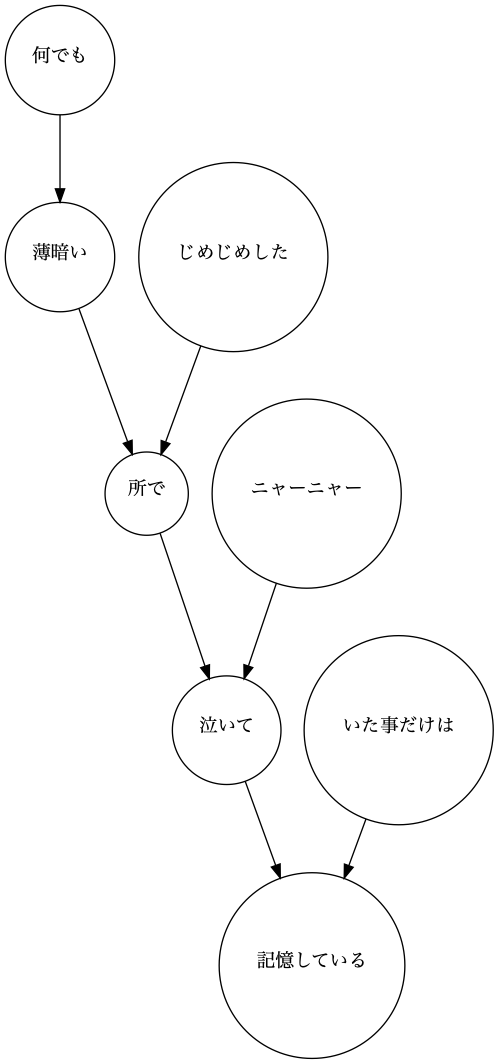

In [133]:
from IPython.display import Image,display_png
display_png(Image('tree.png'))

# 45 動詞の各パターンの抽出

In [157]:
with open("res_45.txt","w") as outFile:
    for chunks in chunk_lines():
        for chunk in chunks:
            chunk_with_verbs= chunk.get_pos_in_morphs("動詞")
            if len(chunk_with_verbs)==0:
                #動詞を含まない
                continue
            #助詞で動詞へかかってるやつ
            particles=[]
            for src in chunk.srcs:
                particles_in_chunk = chunks[src].get_pos_in_morphs("助詞")
                if len(particles_in_chunk)>0:
                    particles.extend(particles_in_chunk)
            verb=chunk_with_verbs[0]
            if len(particles)>0:
                outFile.write("{}\t{}\n".format(verb.base,' '.join(sorted(prt.surface for prt in particles))))
                
            

In [158]:
! head res_45.txt

生れる	で
つく	か が
泣く	で
する	だけ て は
始める	で
見る	は を
聞く	で
捕える	を
煮る	て
食う	て


## Unix　確認

In [155]:
! ls 

chap5.ipynb      res.txt          res_47.txt       result.png
neko.txt         res_45.txt       res_48.txt       tree
neko.txt.cabocha res_46.txt       res_49.txt       tree.png


## 頻出する述語と格パターンの組み合わせ

In [159]:
! sort res_45.txt | uniq -c | sort --numeric-sort --reverse

 565 云う	と
 442 する	を
 249 思う	と
 199 ある	が
 189 なる	に
 174 する	に
 173 見る	て
 127 する	と
 117 する	が
 105 する	に を
  94 見る	を
  92 見える	と
  86 する	て を
  60 もつ	を
  59 する	は
  58 する	て
  57 する	が を
  56 云う	を
  56 ある	の
  51 行く	へ
  49 出来る	が
  48 する	から
  48 云う	て と
  45 聞く	を
  45 ある	も
  43 する	で を
  42 する	と を
  40 なる	が に
  40 する	の
  40 ある	に
  38 思う	か と
  38 ある	が に
  38 食う	を
  38 する	も
  37 云う	が と
  37 ある	は
  35 至る	に
  34 知る	を
  34 する	で
  33 する	から を
  32 来る	が
  31 よる	に
  31 やる	を
  30 する	と は
  30 出る	が
  30 いう	と
  29 する	に は
  29 出す	を
  29 なる	と
  28 する	は を
  28 する	が に
  28 持つ	を
  27 なる	て に
  26 ある	が は
  24 云う	とか
  24 云う	と は
  24 云う	か と
  24 読む	を
  24 とる	を
  23 いる	に
  22 云う	から と
  22 ある	が に は
  22 なる	に は
  22 する	が と
  22 なる	が
  21 見る	て て
  21 云う	と に
  21 なる	に も
  20 つける	を
  20 見る	から
  20 する	て に
  20 行く	て
  20 向う	に
  20 入る	に
  19 する	て と
  19 逢う	に
  19 行く	に
  18 見る	て を
  17 聞く	か と
  17 思う	て と
  17 する	て は
  17 分る	か
  16 云う	から
  16 得る	を
  16 出る	へ
  16 ある	と
  15 知れる	かも
  15 這入る	へ
  15 出来る	も
  15 する	と は を
  15 ある	に は
  15 

   1 知れる	か �� は
   1 着ける	に も を
   1 眺める	と の を
   1 眺める	て は は
   1 眺める	て て を
   1 眺める	が て と
   1 眠れる	が て は
   1 相成る	と に の
   1 用いる	に も を
   1 用いる	が に は
   1 生れる	と に も
   1 生れる	て に は
   1 生じる	と に を
   1 生きる	に は や
   1 生える	で に の
   1 生える	が に は
   1 照らす	て で も
   1 照らす	が に に
   1 潰せる	で な は
   1 済ます	て に を
   1 清める	で に を
   1 添える	て は を
   1 消える	に の も
   1 消える	に に は
   1 流れる	ね は へ
   1 流れる	が に は
   1 流れる	が て を
   1 流れる	が て と
   1 求める	て は を
   1 欠ける	が と は
   1 欠ける	が と と
   1 欠ける	が が は
   1 横切る	が に を
   1 構える	に の も
   1 極める	に は は
   1 極める	に の を
   1 極める	て は を
   1 極まる	で に は
   1 来たす	て で は
   1 来たす	が て て
   1 曲げる	と な を
   1 断わる	が と よ
   1 敬する	て に は
   1 教える	と に は
   1 教える	と な は
   1 教える	が と に
   1 教える	か で は
   1 撫でる	と へ を
   1 撫でる	と に を
   1 撫でる	て と を
   1 撫でる	て て を
   1 撫でる	が と を
   1 撫でる	が で を
   1 撓める	が に を
   1 換える	て て は
   1 揚げる	て は を
   1 提げる	に は を
   1 掛ける	で に を
   1 据わる	が に ば
   1 据える	で へ を
   1 据える	が に は
   1 捧げる	て も を
   1 捕える	が に を
   1 拵える	が て は
   1 拡げる	に の を
   1 抱える	て は も
   1 抜ける	

## する という動詞の格パターン

In [160]:
! grep "^する\s" res_45.txt | sort | uniq -c | sort --numeric-sort --reverse

 442 する	を
 174 する	に
 127 する	と
 117 する	が
 105 する	に を
  86 する	て を
  59 する	は
  58 する	て
  57 する	が を
  48 する	から
  43 する	で を
  42 する	と を
  40 する	の
  38 する	も
  34 する	で
  33 する	から を
  30 する	と は
  29 する	に は
  28 する	は を
  28 する	が に
  22 する	が と
  20 する	て に
  19 する	て と
  17 する	て は
  15 する	と は を
  13 する	が に を
  12 する	から に
  12 する	に も
  11 する	に は を
  11 する	が で を
  11 する	が で
  11 する	か
  10 する	て は を
  10 する	て に を
  10 する	が と を
  10 する	と も
  10 する	て も
  10 する	ば
   9 する	まで
   9 する	て と を
   9 する	で も
   8 する	でも
   8 する	で に
   8 する	て て
   7 する	くらい に
   7 する	まで を
   7 する	さえ
   7 する	で に を
   7 する	が て を
   7 する	は も
   7 する	に に
   7 する	が は
   7 する	へ
   6 する	くらい
   6 する	から も
   6 する	から が
   6 する	に まで
   6 する	に に を
   6 する	て に は
   6 する	て て を
   6 する	が て に
   6 する	と に
   6 する	が も
   5 する	をもって
   5 する	なんか
   5 する	でも を
   5 する	から と
   5 する	と など
   5 する	と に は を
   5 する	に も を
   5 する	と に は
   5 する	が て は
   5 する	も を
   5 する	に の
   5 する	て の
   5 する	が て
   5 する	か と
   4 する	だって
   4 する	から と を
   4 する	だけ は
   4 する	たり を
 

## 見る　という動詞の格パターン

In [161]:
! grep "^見る\s" res_45.txt | sort | uniq -c | sort --numeric-sort --reverse

 173 見る	て
  94 見る	を
  21 見る	て て
  20 見る	から
  18 見る	て を
  14 見る	と
  12 見る	から て
  12 見る	で
  11 見る	て は
   8 見る	に
   7 見る	に を
   7 見る	が を
   7 見る	が
   6 見る	て は を
   5 見る	で を
   5 見る	て と
   4 見る	から を
   4 見る	て て は
   4 見る	と を
   4 見る	て も
   4 見る	が て
   3 見る	て ので
   3 見る	て て を
   3 見る	は を
   3 見る	か て
   3 見る	も
   3 見る	は
   2 見る	から て は
   2 見る	から て て
   2 見る	たり て
   2 見る	て まで
   2 見る	で は を
   2 見る	て に を
   2 見る	て と は
   2 見る	て で も
   2 見る	て で は
   2 見る	て て ば
   2 見る	て て て
   2 見る	が て は
   2 見る	と は
   2 見る	て ば
   2 見る	て に
   2 見る	の
   2 見る	か
   1 見る	によって も
   1 見る	に従って
   1 見る	ながら は を
   1 見る	ながら に を
   1 見る	なんか
   1 見る	から ながら
   1 見る	から から たり と
   1 見る	たり たり て て に
   1 見る	から んで
   1 見る	から じゃ
   1 見る	から て て を
   1 見る	から て て は
   1 見る	から て て と
   1 見る	から て て て
   1 見る	って に を
   1 見る	たり て て
   1 見る	じゃ て に
   1 見る	から て を
   1 見る	から て に
   1 見る	まで を
   1 見る	だけ も
   1 見る	さえ て
   1 見る	から に
   1 見る	から で
   1 見る	より
   1 見る	すら
   1 見る	て について は
   1 見る	と ながら ので
   1 見る	て なんぞ に に は を
   1 見る	て として に
   1

## 与える　という動詞の格パターンの

In [162]:
! grep "^与える\s" res_45.txt | sort | uniq -c | sort --numeric-sort --reverse

   3 与える	に を
   2 与える	て に は を
   1 与える	けれども に は を
   1 与える	だけ で に を
   1 与える	たり て に を
   1 与える	に に対して のみ は は も
   1 与える	か じゃあ て と は を
   1 与える	か として を
   1 与える	が て て と に は は を
   1 与える	て に に は を
   1 与える	て も を
   1 与える	て に を
   1 与える	け に を
   1 与える	ば を
   1 与える	が を


# 46 動詞の各フレーム情報の抽出

In [ ]:
with open("res_46.txt","w") as outFile:
    for chunks in chunk_lines():
        for chunk in chunks:
            chunk_with_verbs= chunk.get_pos_in_morphs("動詞")
            if len(chunk_with_verbs)==0:
                #動詞を含まない
                continue
            #助詞で動詞へかかってるやつ
            particles=[]
            for src in chunk.srcs:
                #助詞のlist
                particles_in_chunk = chunks[src].get_pos_in_morphs("助詞")
                if len(particles_in_chunk)>0:
                    particles.extend(particles_in_chunk)
            verb=chunk_with_verbs[0]
            if len(particles)>0:
                outFile.write("{}\t{}\n".format(verb.base,' '.join(sorted(prt.surface for prt in particles))))
                
            

In [ ]:
! head res_46.txt

# 47

In [ ]:
parse()

In [ ]:
with open("res_47.txt","w") as out_file:
    for chunks in chunk_lines():
        for chunk in chunks:
            verbs = chunk.get_pos_in_morphs("動詞")
            if len(verbs)<1:
                continue
            
            chunks_include_prt=[]
            for src in chunk.srcs:
                if len(chunks[src].get_kaku_prt()) >0:
                    chunks_include_prt.append(chunks[src])
            if len(chunks_include_prt)<1:
                continue
            
            sahen_wo=''
            for chunk_src in chunks_include_prt:
                sahen_wo = chunk_src.get_sahen_wo()
                if len(sahen_wo)>0:
                    chunk_remove = chunk_src
                    break
            if len(sahen_wo)<1:
                continue
                
            chunks_include_prt.remove(chunk_remove)
            
            chunks_include_prt = sorted(chunks_include_prt,key=lambda x:x.get_kaku_prt())
            
            out_file.write("{}\t{}\t{}\n".format(
                           sahen_wo+verbs[0].base,
                            ' '.join([chunk.get_kaku_prt() for chunk in chunks_include_prt]),
                            ' '.join([chunk.normalized_surface() for chunk in chunks_include_prt])
            ))
                

In [ ]:
! head res_47.txt

# 48

In [ ]:
parse()

In [ ]:
with open("res_48.txt","w") as out_file:
    for chunks in chunk_lines():
        for chunk in chunks:
            if len(chunk.get_pos_in_morphs('名詞'))>0:
                out_file.write(chunk.normalized_surface())
                dst = chunk.dst
                while dst != -1:
                    out_file.write(' ->' + chunks[dst].normalized_surface())
                    dst = chunks[dst].dst
                out_file.write("\n")

In [ ]:
! head res_48.txt

# 49

In [ ]:
parse()

In [ ]:
with open("res_49.txt","w") as out_file:
    for chunks in chunk_lines():
        indexs_noun = [i for i in range(len(chunks)) if len(chunks[i].get_pos_in_morphs('名詞'))>0]
        
        
        if len(indexs_noun)<2:
            continue
        
        for i,index_x in enumerate(indexs_noun[:-1]):
            for index_y in indexs_noun[i+1:]:
                meet_y=False
                index_dup=-1
                routes_x=set()
                
                dst = chunks[index_x].dst
                while dst!=-1:
                    if dst==index_y:
                        meet_y=True
                        break
                    routes_x.add(dst)
                    dst = chunks[dst].dst
                
                if not meet_y:
                    dst = chunks[index_y].dst
                    while dst != -1:
                        if dst in routes_x:
                            index_dup = dst
                            break
                        else:
                            dst = chunks[dst].dst
                if index_dup==-1:
                    out_file.write(chunks[index_x].noun_masked_surface("X"))
                    dst = chunks[index_x].dst
                    while dst != -1:
                        if dst == index_y:
                            out_file.write(" ->" + chunks[dst].noun_masked_surface('Y',True))
                            break
                        else:
                            out_file.write(" ->" +chunks[dst].normalized_surface())
                        dst = chunks[dst].dst
                    out_file.write("\n")
                    
                else:
                    out_file.write(chunks[index_x].noun_masked_surface('X'))
                    dst = chunks[index_x].dst
                    while dst != index_dup:
                        out_file.write(" ->" + chunks[dst].normalized_surface())
                        dst = chunks[dst].dst
                    out_file.write(" | ")
                    
                    out_file.write(chunks[index_y].noun_masked_surface('Y'))
                    dst = chunks[index_y].dst
                    while dst != index_dup:
                        out_file.write(" -> "+chunks[dst].normalized_surface())
                        dst = chunks[dst].dst
                    out_file.write(" | ")
                    
                    out_file.write(chunks[index_dup].normalized_surface())
                    out_file.write("\n")
                    
        

In [ ]:
! head res_49.txt